In [1]:
import numpy as np
from numpy import matlib
import matplotlib.pyplot as plt
import scipy
import matplotlib
import tqdm
from scipy import integrate, fft, sparse
import pandas as pd
import seaborn as sns
import random
import anndata
import os
from sklearn.metrics import confusion_matrix
import loompy as lp

from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import kneighbors_graph

import igraph as ig
import leidenalg as la

from sklearn.metrics import adjusted_rand_score

Set path for Monod package

In [2]:
import sys
import importlib
sys.path.insert(0, '/home/tchari/monod/src/')

In [3]:
import monod
#importlib.reload(monod)
from monod import preprocess, extract_data, cme_toolbox, inference, analysis, mminference

In [4]:
import warnings
warnings.filterwarnings('ignore', category=PendingDeprecationWarning) 

## **Define Functions for Simulations**

In [5]:
class BurstModel():
    """
    Given parameters for bursty transcription, splicing, deg generate P(U,S) for set of (U,S) counts
    """
    def __init__(self,seq_model='None',quad_method='fixed_quad',fixed_quad_T=10,quad_order=60,quad_vec_T=np.inf):
        self.seq_model = seq_model
        self.quad_method = quad_method
        self.fixed_quad_T = fixed_quad_T
        self.quad_order = quad_order
        self.quad_vec_T = quad_vec_T
        
    def burst_intfun(self, x, g, b, beta, gamma):
        if np.isclose(beta, gamma):
            c_1 = g[0]  
            c_2 = x * beta * g[1]
        else:
            f = beta / (beta - gamma)
            c_2 = g[1] * f
            c_1 = g[0] - c_2

        U = b * (np.exp(-beta * x) * c_1 + np.exp(-gamma * x) * c_2)
        return U / (1 - U)    
    
    def eval_model_pgf(self, p_, g):
        p = 10**p_
        b, beta, gamma = p

        
        fun = lambda x: self.burst_intfun(x, g, b, beta, gamma)
        if self.quad_method == "quad_vec":
            T = self.quad_vec_T * (1 / beta + 1 / gamma + 1)
            gf = scipy.integrate.quad_vec(fun, 0, T)[0]
        elif self.quad_method == "fixed_quad":
            T = self.fixed_quad_T * (1 / beta + 1 / gamma + 1)
            gf = scipy.integrate.fixed_quad(fun, 0, T, n=self.quad_order)[0]
        else:
            raise ValueError("Please use one of the specified quadrature methods.")
        return gf  # this is the log-generating function

    def get_Pss(self, p, limits, samp=None):
        u = []
        mx = np.copy(limits)
        mx[-1] = mx[-1] // 2 + 1
        for i in range(len(mx)):
            l = np.arange(mx[i])
            u_ = np.exp(-2j * np.pi * l / limits[i]) - 1
            u.append(u_)
        g = np.meshgrid(*[u_ for u_ in u], indexing="ij")
        for i in range(len(mx)):
            g[i] = g[i].flatten()
        g = np.asarray(g)[:, :, None]

        if self.seq_model == "Bernoulli":
            g *= np.asarray(samp)[:, None, None]
        elif self.seq_model == "Poisson":
            g = np.exp((np.power(10, samp))[:, None, None] * g) - 1

        gf = self.eval_model_pgf(p, g)
        gf = np.exp(gf)
        gf = gf.reshape(tuple(mx))
        
        
        Pss = scipy.fft.irfftn(gf, s=tuple(limits))
        
        
        Pss = np.abs(Pss) / np.sum(np.abs(Pss))
        
        Pss = Pss.squeeze()
        return Pss

In [6]:
def sample_from_p(num_data_points, Pss):
    """
    Given a P(U,S) distribution, sample (U,S) counts
    N = U (nascent/unspliced)
    M = S (mature/spliced)
    """
    mx = Pss.shape
    p_flat = Pss.flatten()
    x_N, x_M = np.arange(mx[0]), np.arange(mx[1])
    X_N, X_M = np.meshgrid(x_N, x_M, indexing='ij')    # get grid of possible values
    x_choices = np.arange(np.prod(mx))                 # represent each grid point as a point in a 1D vector
    
    samples = np.random.choice(x_choices, size=num_data_points, replace=True, p=p_flat)
    d_N, d_M = X_N.flatten()[samples], X_M.flatten()[samples]    
    return d_N, d_M

## **Generate Counts**

In [7]:
def make_params(clus,n_genes,lens_sub,samples,glob_samp,num_marks,p=1.0,loc=1.5,single_param=None):
    """
    Given number of clusters (states),genes, and markers per cluster, generate parameters per cluster (state).
    With probability p add noise to b for markers (and change other params with p=1-p)
    """
    #For each gene set params (clus x n_genes x 6), use gene lens from transcriptome file + use same gene names 
    params = np.zeros((clus,n_genes,6)) #b,k,beta,gamma,samp_n,samp_m, ALL LOG10
    for g in range(n_genes):
        g_len = lens_sub[g]
        params[:,g,0] = samples[g,0] + np.random.randn()*0.05 #int(np.random.uniform(8,12)) #b
        params[:,g,1] = 0 #np.random.uniform(0.1,0.5) #k
        params[:,g,2] = samples[g,1] + np.random.randn()*0.05 #np.random.normal(2,0.1)  #beta
        params[:,g,3] = samples[g,2] + np.random.randn()*0.05 #np.random.normal(0.8,0.1) #gamma

        params[:,g,4] = (glob_samp[0]) + np.log10(g_len) #C_nL
        params[:,g,5] = (glob_samp[1]) #lam_m



    #For each clus, select num_marks unique markers, add noise to b (log10b)
    all_choices = np.random.choice(range(n_genes), num_marks*clus, replace=False)
    if num_marks > 0:
        for c in range(clus):
            marks = all_choices[c*num_marks:(c+1)*num_marks]

            #UPDATE to change either b or beta&gamma
            for m in marks:
                if np.random.rand() < p:
                    params[c,m,0] += loc+np.random.randn()*0.1 #np.random.normal(loc=loc, scale = 0.1) #Only in burst size
                elif single_param == 'beta':
                    params[c,m,2] -= loc+np.random.randn()*0.1
                elif single_param == 'gamma':
                    params[c,m,3] -= loc+np.random.randn()*0.1
                else: 
                    params[c,m,2] -= loc+np.random.randn()*0.1 #np.random.normal(loc=loc, scale = 0.1)
                    params[c,m,3] -= loc+np.random.randn()*0.1 #np.random.normal(loc=loc, scale = 0.1)

    return params,all_choices


In [8]:
def make_all_params(clus,n_genes,lens_sub,samples,glob_samp,num_marks,p=1.0,loc=1.5,locb=1.5):
    """
    Given number of clusters (states),genes, and markers per cluster, generate parameters per cluster (state).
    With probability p add noise to b for markers (and change other params with p=1-p) or change all params
    """
    #Change (1) all parameters at once or (2) b or beta/gamma with prob p
    params = np.zeros((clus,n_genes,6)) #b,k,beta,gamma,samp_n,samp_m, ALL LOG10
    for g in range(n_genes):
        g_len = lens_sub[g]
        params[:,g,0] = samples[g,0] + np.random.randn()*0.05 #int(np.random.uniform(8,12)) #b
        params[:,g,1] = 0 #np.random.uniform(0.1,0.5) #k
        params[:,g,2] = samples[g,1] + np.random.randn()*0.05 #np.random.normal(2,0.1)  #beta
        params[:,g,3] = samples[g,2] + np.random.randn()*0.05 #np.random.normal(0.8,0.1) #gamma

        params[:,g,4] = (glob_samp[0]) + np.log10(g_len) #C_nL
        params[:,g,5] = (glob_samp[1]) #lam_m



    #For each clus, select num_marks unique markers, add noise to b (log10b)
    all_choices = np.random.choice(range(n_genes), num_marks*clus, replace=False)
    if num_marks > 0:
        for c in range(clus):
            marks = all_choices[c*num_marks:(c+1)*num_marks]

            #UPDATE to change either b or beta&gamma
            for m in marks:
                if np.random.rand() < p:
                    if np.random.rand() < 0.5:
                        params[c,m,0] += locb+np.random.randn()*0.1 
                    else:
                        params[c,m,2] -= loc+np.random.randn()*0.1 #np.random.normal(loc=loc, scale = 0.1)
                        params[c,m,3] -= loc+np.random.randn()*0.1
                else:
                    params[c,m,0] += locb+np.random.randn()*0.1
                    params[c,m,2] += loc+np.random.randn()*0.1
                    params[c,m,3] += loc+np.random.randn()*0.1
                    

    return params,all_choices


In [9]:
def make_counts(clus,n_cells,n_genes,params):
    """
    For each cluster+gene, generate counts (U,S) from parameters 
    """
    #Given parameters, sample counts from resulting probability distribution
    all_counts = np.zeros((clus*n_cells,n_genes,2))
    for c in range(clus):

        for g in range(n_genes):

            b = 10**params[c,g,0]
            k = 10**params[c,g,1]
            beta = 10**params[c,g,2]
            gamma = 10**params[c,g,3]

            lam_n = 10**params[c,g,4]
            lam_m = 10**params[c,g,5]

            p = np.log10(np.asarray([b,beta/k,gamma/k]))
            burst_model = BurstModel('Poisson')

            max_mean = b*np.asarray([lam_n/beta,lam_m/gamma]) #np.array(samp)*
            #max_std = np.sqrt(max_mean*(1+ b*np.asarray([1,beta/(beta+gamma)])))

            max_std = np.sqrt(max_mean*(1+np.asarray([lam_n*(1+b), lam_m*(1+b*beta/(beta+gamma))])))

            max_domain = np.maximum((max_mean + 4*max_std).astype(int),15)
            #max_domain = [int(i) for i in max_domain]

            Pss = burst_model.get_Pss(p,max_domain,np.log10([lam_n,lam_m]))

            #Get N and M count samples
            sampled = sample_from_p(n_cells, Pss)
            all_counts[c*n_cells:(c+1)*n_cells,g,0] = sampled[0]
            all_counts[c*n_cells:(c+1)*n_cells,g,1] = sampled[1]
            
    return all_counts

Set parameters for simulation

In [10]:
#No. of cells PER k cell 'type'/stats
n_cells = 200
clus = 10 #No. of states to simulate

In [11]:
n_genes = 500 #No. genes
num_marks = 20 #No. markers per state

In [12]:
#Technical sampling params
glob_samp = np.asarray([-7.157894736842105, -1.525])

In [13]:
transcriptome = pd.read_csv('/home/tchari/perturbCME/notebooks/gg_200525_genome_polyA_cum_3',delim_whitespace=True,header = None)
transcriptome.head()

,0,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
0,TNMD,14950,48,23,10,5,2,2,2,2,...,0,0,0,0,0,0,0,0,0,0
1,DPM1,23689,98,38,25,17,10,6,5,5,...,0,0,0,0,0,0,0,0,0,0
2,SCYL3,44637,132,51,20,13,9,7,6,4,...,0,0,0,0,0,0,0,0,0,0
3,TSPAN6,12884,43,18,13,8,3,2,2,1,...,0,0,0,0,0,0,0,0,0,0
4,FGR,23122,41,18,8,4,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [14]:
#Initialize params and correlations, per gene
np.random.seed(40)

mean = np.asarray([1.2, 0.2, 0.5, 5]) #b, beta, gamma, L 
std = np.asarray([0.6, 0.3, 0.5, 0.5]) 
var = std[:, None] * std[None, :] #Make covariance matrix
rho = [0.8, 0.8, 0.8, -0.1, 0, 0] #Incorporate corrs b/w params
pairs = [[1, 2], [0, 1], [0, 2], [0, 3], [1, 3], [2, 3]]
for k, p in enumerate(pairs):
    var[p[0], p[1]] *= rho[k]
    var[p[1], p[0]] *= rho[k]
samples = np.random.multivariate_normal(mean, var, n_genes)


In [15]:
samples.shape

(500, 4)

In [16]:
#Select genes from real transcriptome

gene_names = np.array(transcriptome[0])

names_sub = gene_names[0:n_genes]


transcriptome_sub = transcriptome[0:n_genes]
lens_sub = 10**samples[:,3]
transcriptome_sub[1] = [int(i) for i in lens_sub]
transcriptome_sub.head()

#make new transcriptome in same style
transcriptome_sub.to_csv('/home/tchari/perturbCME/notebooks/mmSim_edgecase_genome_polyA_cum_3',sep=' ', index=False)



/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


Get (U,S) counts for each simulation setting

In [701]:
all_params = []
all_marks = []


out = make_params(clus,n_genes,lens_sub,samples,glob_samp,num_marks,p=0.5,loc=1.5,single_param='beta')
all_params += [out[0]]
all_marks += [out[1]]

out = make_all_params(clus,n_genes,lens_sub,samples,glob_samp,num_marks,p=0.1,loc=1.5,locb=1.5)

all_params += [out[0]]
all_marks += [out[1]]

In [702]:
len(all_counts)

2

In [703]:
all_counts = []
for params in all_params:
    all_counts += [make_counts(clus,n_cells,n_genes,params)]

In [27]:
all_assigns = []
for c in range(clus):
    all_assigns += [c]*n_cells

In [705]:
all_counts[0].shape

(2000, 500, 2)

In [764]:
#Save all params and all marks
out_path = '/home/tchari/counts/mixMod_edgecase_sims/loom/'

print(np.array(all_params).shape)
np.save(out_path+'all_params.npy',np.array(all_params))
np.save(out_path+'all_marks.npy',np.array(all_marks))

(2, 10, 500, 6)


**Make sure sims look ok**

Text(0, 0.5, 'log beta (beta)')

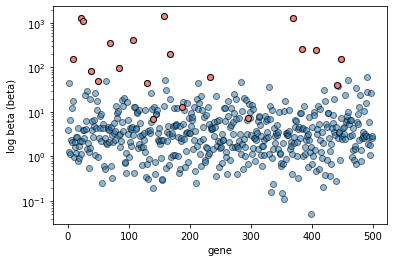

In [707]:
test_out = all_params[-1]
test_marks = all_marks[-1][0:num_marks]

plt.scatter(range(len(test_out[0,:,0])), 10**test_out[0,:,3],alpha=0.5,edgecolor='black')
plt.scatter(np.array(range(len(test_out[0,:,0])))[test_marks], 10**test_out[0,:,3][test_marks],color='salmon',alpha=0.9,edgecolor='black')
plt.yscale('log')
plt.xlabel('gene')
plt.ylabel('log beta (beta)')

Text(0, 0.5, 'log burst size (b)')

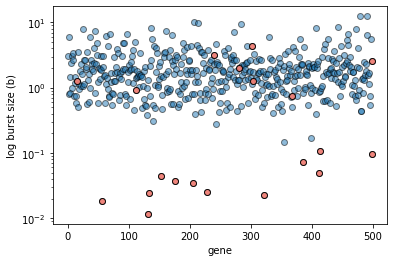

In [708]:
test_out = all_params[0]
test_marks = all_marks[0][0:num_marks]

plt.scatter(range(len(test_out[0,:,2])), 10**test_out[0,:,2],alpha=0.5,edgecolor='black')
plt.scatter(np.array(range(len(test_out[0,:,2])))[test_marks], 10**test_out[0,:,2][test_marks],color='salmon',alpha=0.9,edgecolor='black')
plt.yscale('log')
plt.xlabel('gene')
plt.ylabel('log burst size (b)')

[[1.         0.43436067]
 [0.43436067 1.        ]]


Text(0, 0.5, 'param mean U')

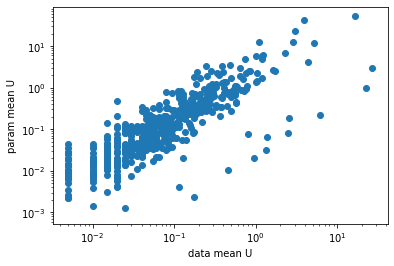

In [709]:
#Check relationship between means and means from params
k1 = all_counts[0][0:200,:,:]
k1.shape

sim_mean = test_out[0,:,0]+test_out[0,:,4]-test_out[0,:,1]
plt.scatter(np.mean(k1[:,:,0],axis=0),10**sim_mean )
print(np.corrcoef(np.mean(k1[:,:,0],axis=0),10**(sim_mean )))
plt.xscale("log")
plt.yscale("log")
plt.xlabel('data mean U')
plt.ylabel('param mean U')

In [710]:
test_cluster = all_counts[-1]

In [711]:
concat_types = np.concatenate((np.mean(test_cluster[0:200,:,:],axis=0),np.mean(test_cluster[200:400,:,:],axis=0),
          np.mean(test_cluster[400:600,:,:],axis=0)),axis=1)


[Text(1, 0.5, '256'),
 Text(1, 1.5, '62'),
 Text(1, 2.5, '492'),
 Text(1, 3.5, '58'),
 Text(1, 4.5, '476'),
 Text(1, 5.5, '311'),
 Text(1, 6.5, '41'),
 Text(1, 7.5, '331'),
 Text(1, 8.5, '32'),
 Text(1, 9.5, '213'),
 Text(1, 10.5, '174'),
 Text(1, 11.5, '288'),
 Text(1, 12.5, '168'),
 Text(1, 13.5, '234'),
 Text(1, 14.5, '310'),
 Text(1, 15.5, '89'),
 Text(1, 16.5, '217'),
 Text(1, 17.5, '406'),
 Text(1, 18.5, '92'),
 Text(1, 19.5, '224'),
 Text(1, 20.5, '496'),
 Text(1, 21.5, '230'),
 Text(1, 22.5, '133'),
 Text(1, 23.5, '240'),
 Text(1, 24.5, '160'),
 Text(1, 25.5, '301'),
 Text(1, 26.5, '157'),
 Text(1, 27.5, '159'),
 Text(1, 28.5, '162'),
 Text(1, 29.5, '283'),
 Text(1, 30.5, '297'),
 Text(1, 31.5, '340'),
 Text(1, 32.5, '477'),
 Text(1, 33.5, '76'),
 Text(1, 34.5, '208'),
 Text(1, 35.5, '126'),
 Text(1, 36.5, '279'),
 Text(1, 37.5, '228'),
 Text(1, 38.5, '244'),
 Text(1, 39.5, '266'),
 Text(1, 40.5, '1'),
 Text(1, 41.5, '31'),
 Text(1, 42.5, '53'),
 Text(1, 43.5, '419'),
 Text(1, 

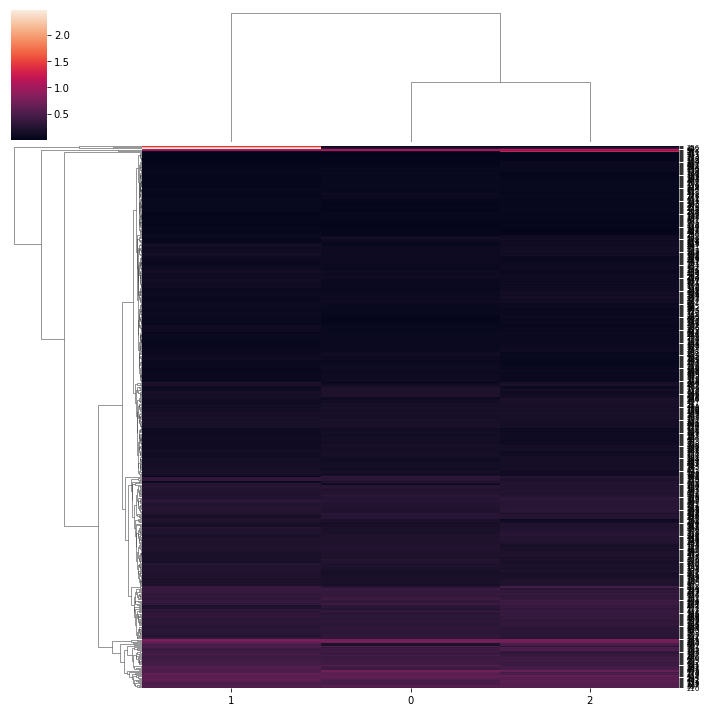

In [712]:
#How separated are clusters by 'DE genes,', cluster on spliced counts
g = sns.clustermap(np.log1p(concat_types[:,[1,3,5]]),yticklabels=True)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize = 7)



[Text(1, 0.5, '311'),
 Text(1, 1.5, '490'),
 Text(1, 2.5, '92'),
 Text(1, 3.5, '270'),
 Text(1, 4.5, '58'),
 Text(1, 5.5, '13'),
 Text(1, 6.5, '63'),
 Text(1, 7.5, '190'),
 Text(1, 8.5, '430'),
 Text(1, 9.5, '212'),
 Text(1, 10.5, '37'),
 Text(1, 11.5, '338'),
 Text(1, 12.5, '142'),
 Text(1, 13.5, '39'),
 Text(1, 14.5, '152'),
 Text(1, 15.5, '285'),
 Text(1, 16.5, '414'),
 Text(1, 17.5, '23'),
 Text(1, 18.5, '460'),
 Text(1, 19.5, '387'),
 Text(1, 20.5, '390'),
 Text(1, 21.5, '167'),
 Text(1, 22.5, '242'),
 Text(1, 23.5, '497'),
 Text(1, 24.5, '246'),
 Text(1, 25.5, '55'),
 Text(1, 26.5, '59'),
 Text(1, 27.5, '171'),
 Text(1, 28.5, '237'),
 Text(1, 29.5, '150'),
 Text(1, 30.5, '227'),
 Text(1, 31.5, '412'),
 Text(1, 32.5, '213'),
 Text(1, 33.5, '448'),
 Text(1, 34.5, '256'),
 Text(1, 35.5, '492'),
 Text(1, 36.5, '331'),
 Text(1, 37.5, '446'),
 Text(1, 38.5, '83'),
 Text(1, 39.5, '230'),
 Text(1, 40.5, '225'),
 Text(1, 41.5, '317'),
 Text(1, 42.5, '413'),
 Text(1, 43.5, '368'),
 Text(1,

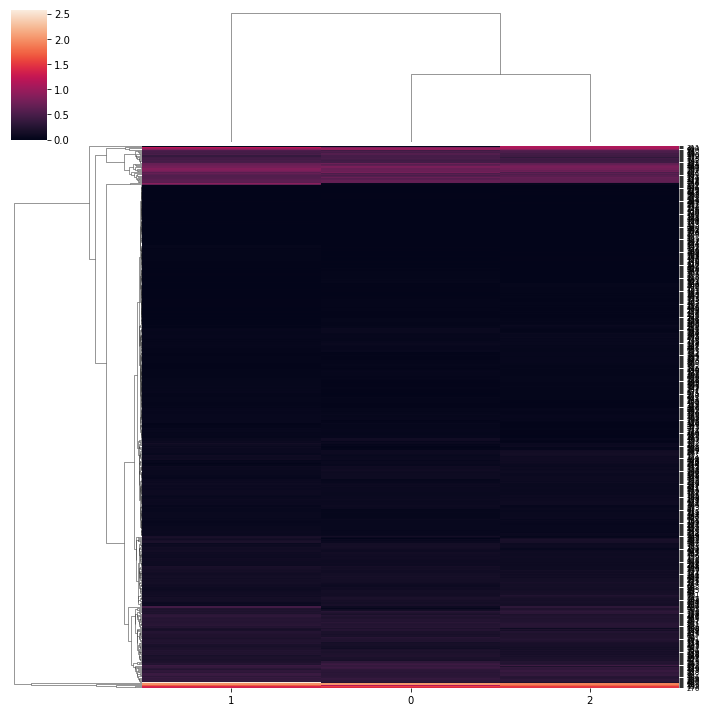

In [713]:
#How separated are clusters by 'DE genes,', cluster on unspliced counts
g = sns.clustermap(np.log1p(concat_types[:,[0,2,4]]),yticklabels=True)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize = 7)



Text(0, 0.5, 'Mature counts')

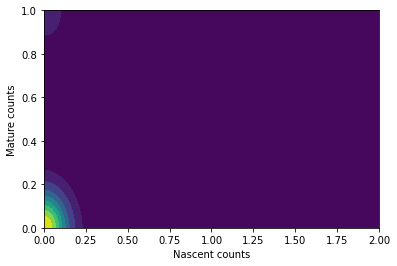

In [714]:
plt.figure()
test_gene = k1[:,50,:]
sns.kdeplot(x=test_gene[:,0], y=test_gene[:,1], cmap="viridis", shade=True, thresh=0)
plt.xlim(np.min(test_gene[:,0]),np.max(test_gene[:,0]))
plt.ylim(np.min(test_gene[:,1]),np.max(test_gene[:,1]))
plt.xlabel('Nascent counts')
plt.ylabel('Mature counts')


In [715]:
np.max(k1)

128.0

**Save count matrices for Monod**

In [466]:
!mkdir ~/counts/mixMod_edgecase_sims
!mkdir ~/counts/mixMod_edgecase_sims/loom/

mkdir: cannot create directory ‘/home/tchari/counts/mixMod_edgecase_sims’: File exists
mkdir: cannot create directory ‘/home/tchari/counts/mixMod_edgecase_sims/loom/’: File exists


In [17]:
out_names = ['beta80_sim_k10','all90_sim_k10'] 

In [717]:
#And save clus labels for cells + barcodes for each cell in metadata + loom
out_path = '/home/tchari/counts/mixMod_edgecase_sims/loom/'
geneNames = names_sub
for ind in range(len(out_names)):
    U = all_counts[ind][:,:,0]
    S = all_counts[ind][:,:,1]
    
    bars = [str(i) for i in range(n_cells*clus)]

    fname = out_path+out_names[ind]+'.loom'

    print('Making Loom')
    #Make loom of U/S
    retAdata = anndata.AnnData(
                X=sparse.csr_matrix(S),
                layers={
                    'spliced': sparse.csr_matrix(S),
                    'unspliced': sparse.csr_matrix(U),
                },
                obs=pd.DataFrame({'barcode': np.array(bars)},index=np.array(bars)),
                var=pd.DataFrame({'gene_name': geneNames},index=geneNames)
            )

    retAdata.write_loom(fname)
    print(fname)


Making Loom
/home/tchari/counts/mixMod_edgecase_sims/loom/beta80_sim_k10.loom
Making Loom


/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.


/home/tchari/counts/mixMod_edgecase_sims/loom/all90_sim_k10.loom


In [718]:
#----- EXTRA CONTROL: Make loom with just one cluster, for comparing to Monod fits -----
out_path = '/home/tchari/counts/mixMod_edgecase_sims/loom/'
U = all_counts[0][0:n_cells,:,0]
S = all_counts[0][0:n_cells,:,1]
geneNames = names_sub
bs = [str(i) for i in range(n_cells)]

fname = out_path+'oneClus_beta80_sim_k10.loom'

print('Making Loom')
#Make loom of U/S
retAdata = anndata.AnnData(
			X=sparse.csr_matrix(S),
			layers={
				'spliced': sparse.csr_matrix(S),
				'unspliced': sparse.csr_matrix(U),
			},
			obs=pd.DataFrame({'barcode': np.array(bs)},index=np.array(bs)),
			var=pd.DataFrame({'gene_name': geneNames},index=geneNames)
		)

retAdata.write_loom(fname)
print(fname)

Making Loom
/home/tchari/counts/mixMod_edgecase_sims/loom/oneClus_beta80_sim_k10.loom


/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.


In [1016]:
#----- EXTRA CONTROL: Make loom with just one cluster, for comparing to Monod fits -----
out_path = '/home/tchari/counts/mixMod_edgecase_sims/loom/'
U = all_counts[0][2*n_cells:(2*n_cells+n_cells),:,0]
S = all_counts[0][2*n_cells:(2*n_cells+n_cells),:,1]
geneNames = names_sub
bs = [str(i) for i in range(n_cells)]

fname = out_path+'oneClus_beta80_sim_k10_k2.loom'

print('Making Loom')
#Make loom of U/S
retAdata = anndata.AnnData(
			X=sparse.csr_matrix(S),
			layers={
				'spliced': sparse.csr_matrix(S),
				'unspliced': sparse.csr_matrix(U),
			},
			obs=pd.DataFrame({'barcode': np.array(bs)},index=np.array(bs)),
			var=pd.DataFrame({'gene_name': geneNames},index=geneNames)
		)

retAdata.write_loom(fname)
print(fname)

Making Loom
/home/tchari/counts/mixMod_edgecase_sims/loom/oneClus_beta80_sim_k10_k2.loom


/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.


In [719]:
#----- EXTRA CONTROL: Make loom with just one cluster, for comparing to Monod fits, for b,beta and gamma sim -----
out_path = '/home/tchari/counts/mixMod_edgecase_sims/loom/'
U = all_counts[-1][0:n_cells,:,0]
S = all_counts[-1][0:n_cells,:,1]
geneNames = names_sub
bs = [str(i) for i in range(n_cells)]

fname = out_path+'oneClus_all90_sim_k10.loom'

print('Making Loom')
#Make loom of U/S
retAdata = anndata.AnnData(
			X=sparse.csr_matrix(S),
			layers={
				'spliced': sparse.csr_matrix(S),
				'unspliced': sparse.csr_matrix(U),
			},
			obs=pd.DataFrame({'barcode': np.array(bs)},index=np.array(bs)),
			var=pd.DataFrame({'gene_name': geneNames},index=geneNames)
		)

retAdata.write_loom(fname)
print(fname)

Making Loom
/home/tchari/counts/mixMod_edgecase_sims/loom/oneClus_all90_sim_k10.loom


/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.


## **Run Inference**

In [18]:
rep_data = list(np.repeat(out_names,4))+['oneClus_beta80_sim_k10']+['oneClus_beta80_sim_k10_k2']+['oneClus_all90_sim_k10']
ks = [1,5,10,15]*len(out_names)+[1,1,1]

dataset_meta = rep_data #['burst_mark_sim','oneClus_burst_mark_sim']
print('dataset_meta: ', dataset_meta)
print()


cluster_names = []

d_names = []
for i in range(len(ks)):
    d_names += [rep_data[i]+'_k'+str(ks[i])]
    
dataset_names = d_names  #To save
print('dataset_names: ', dataset_names)
print('len(dataset_names): ',len(dataset_names))
print()

raw_data_locations = rep_data 
transcriptome_filepath = '/home/tchari/perturbCME/notebooks/mmSim_edgecase_genome_polyA_cum_3' #'gg_200525_genome_polyA_cum_3'

spliced_layer = 'spliced'
unspliced_layer = 'unspliced'
gene_attr = 'gene_name'
cell_attr = 'barcode'

attribute_names=[(unspliced_layer,spliced_layer),gene_attr,cell_attr]

loom_filepaths = ['/home/tchari/counts/mixMod_edgecase_sims/loom/'+x+'.loom' for x in raw_data_locations] 
print('loom_filepaths: ',loom_filepaths)

n_datasets = len(loom_filepaths)

dataset_meta:  ['beta80_sim_k10', 'beta80_sim_k10', 'beta80_sim_k10', 'beta80_sim_k10', 'all90_sim_k10', 'all90_sim_k10', 'all90_sim_k10', 'all90_sim_k10', 'oneClus_beta80_sim_k10', 'oneClus_beta80_sim_k10_k2', 'oneClus_all90_sim_k10']

dataset_names:  ['beta80_sim_k10_k1', 'beta80_sim_k10_k5', 'beta80_sim_k10_k10', 'beta80_sim_k10_k15', 'all90_sim_k10_k1', 'all90_sim_k10_k5', 'all90_sim_k10_k10', 'all90_sim_k10_k15', 'oneClus_beta80_sim_k10_k1', 'oneClus_beta80_sim_k10_k2_k1', 'oneClus_all90_sim_k10_k1']
len(dataset_names):  11

loom_filepaths:  ['/home/tchari/counts/mixMod_edgecase_sims/loom/beta80_sim_k10.loom', '/home/tchari/counts/mixMod_edgecase_sims/loom/beta80_sim_k10.loom', '/home/tchari/counts/mixMod_edgecase_sims/loom/beta80_sim_k10.loom', '/home/tchari/counts/mixMod_edgecase_sims/loom/beta80_sim_k10.loom', '/home/tchari/counts/mixMod_edgecase_sims/loom/all90_sim_k10.loom', '/home/tchari/counts/mixMod_edgecase_sims/loom/all90_sim_k10.loom', '/home/tchari/counts/mixMod_edgeca

In [19]:
print(n_datasets)

11


Dataset beta80_sim_k10. 
	2000 barcodes in loom, 38 pass filter. 2000 in annotations; of these, 2000 in loom and 38 in filtered loom.
	Keep All: 2000 cells in annotations. 2000 in loom. 2000 pass filter.
Dataset beta80_sim_k10. 
	2000 barcodes in loom, 38 pass filter. 2000 in annotations; of these, 2000 in loom and 38 in filtered loom.
	Keep All: 2000 cells in annotations. 2000 in loom. 2000 pass filter.
Dataset beta80_sim_k10. 
	2000 barcodes in loom, 38 pass filter. 2000 in annotations; of these, 2000 in loom and 38 in filtered loom.
	Keep All: 2000 cells in annotations. 2000 in loom. 2000 pass filter.
Dataset beta80_sim_k10. 
	2000 barcodes in loom, 38 pass filter. 2000 in annotations; of these, 2000 in loom and 38 in filtered loom.
	Keep All: 2000 cells in annotations. 2000 in loom. 2000 pass filter.
Dataset all90_sim_k10. 
	2000 barcodes in loom, 0 pass filter. 2000 in annotations; of these, 2000 in loom and 0 in filtered loom.
	Keep All: 2000 cells in annotations. 2000 in loom. 2

/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


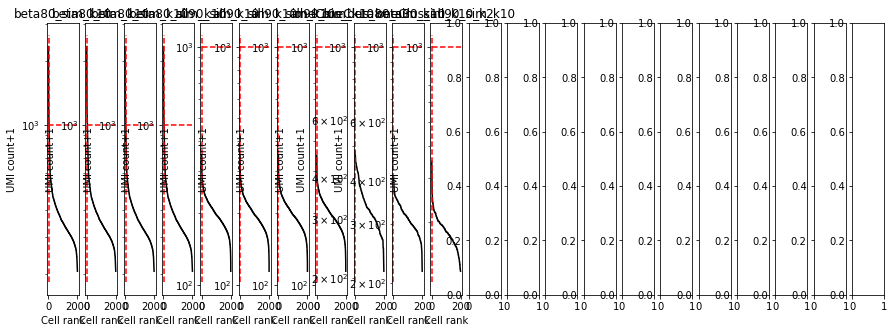

In [20]:
#Following process for filtering cells in Monod, but keeping all simulated cells for now
cf = []
thr_lb = [1e3]*len(dataset_meta)*2

fig1,ax1 = plt.subplots(1,len(dataset_meta)*2,figsize=(15,5))

for k in range(len(dataset_meta)):
    filename = loom_filepaths[k]
    dataset_name = raw_data_locations[k]
    
    with lp.connect(filename,mode='r') as ds:
        S = ds.layers[spliced_layer][:]
        U = ds.layers[unspliced_layer][:]
        gene_names = ds.ra[gene_attr]
        bcs = ds.ca[cell_attr]
        cells = S.shape[1]
        monod.preprocess.knee_plot(S+U,ax1[k],viz=True,thr=thr_lb[k])
        cf_ = ((S+U).sum(0)>thr_lb[k])
        
        n_annot_bcs = len(bcs)
        annot_bcs_in_loom = len(bcs)
        annot_bcs_in_filt_loom = cf_.sum()
        print(f'Dataset {dataset_name}. \n\t{len(bcs)} barcodes in loom, {cf_.sum()} pass filter. {n_annot_bcs} in annotations; of these, {annot_bcs_in_loom} in loom and {annot_bcs_in_filt_loom} in filtered loom.')
        
        #Keep all cell barcodes for now
        subcluster = 'Keep All'
        annot_bcs = bcs
      
        cf.append(np.isin(bcs,annot_bcs))
        print(f'\t{subcluster}: {len(annot_bcs)} cells in annotations. {np.isin(bcs,annot_bcs).sum()} in loom. {cf[-1].sum()} pass filter.')



    ax1[k].set_title(dataset_name)
    
!mkdir ./figs    
fig_dir = './figs/'
fig_string = fig_dir + 'kneeplots_burst_mark_sim_edgecase_forMM.png'
fig1.tight_layout()
plt.savefig(fig_string,dpi=450)

In [21]:
import logging, sys
logging.basicConfig(stream=sys.stdout)
log = logging.getLogger()
log.setLevel(logging.INFO)

In [22]:
#Define bounds, from 20220930_normanfit_monod.ipynb
phys_lb = [-2.0, -1.8, -1.8 ] #-1.0, -1.8, -1.8
phys_ub = [4.2, 2.5, 2.5] #4.2, 2.5, 3.5
samp_lb = [-7.157894736842105, -1.525] #-7.5, -2
samp_ub = [-7.157894736842105, -1.525] #-5.5, 0
# gridsize = [5,6]
gridsize = [1,1]


INFO:root:Beginning data preprocessing and filtering.
INFO:root:Directory ./fits/gg_230505_025_simTests_edgecase_MM_1 already exists.
INFO:root:Dataset: beta80_sim_k10_k1
INFO:root:2000 cells detected.
INFO:root:500 features observed, 500 match genome annotations. 500 were unique.
INFO:root:199 genes retained after expression filter.
INFO:root:Directory ./fits/gg_230505_025_simTests_edgecase_MM_1/beta80_sim_k10_k1 already exists.
INFO:root:Dataset: beta80_sim_k10_k5
INFO:root:2000 cells detected.
INFO:root:500 features observed, 500 match genome annotations. 500 were unique.
INFO:root:199 genes retained after expression filter.
INFO:root:Directory ./fits/gg_230505_025_simTests_edgecase_MM_1/beta80_sim_k10_k5 already exists.
INFO:root:Dataset: beta80_sim_k10_k10
INFO:root:2000 cells detected.
INFO:root:500 features observed, 500 match genome annotations. 500 were unique.
INFO:root:199 genes retained after expression filter.
INFO:root:Directory ./fits/gg_230505_025_simTests_edgecase_MM_1

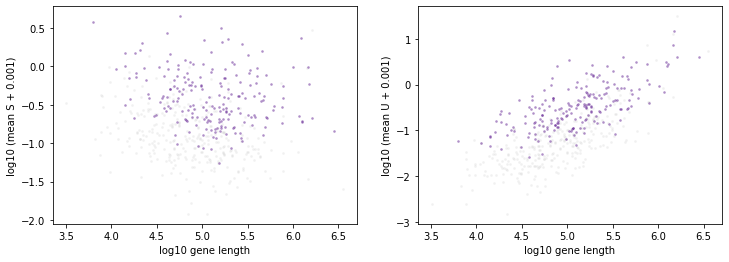

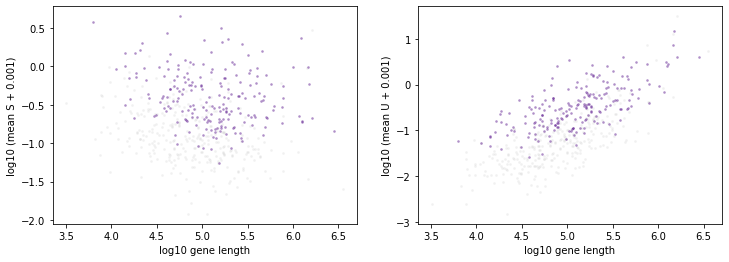

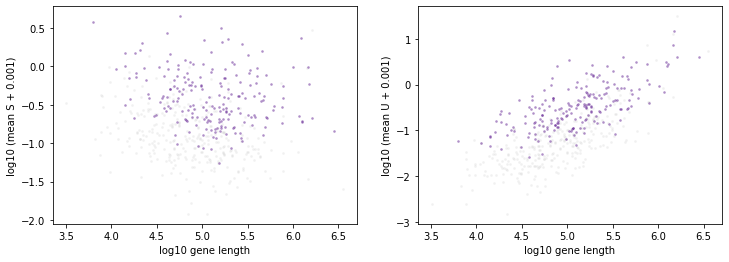

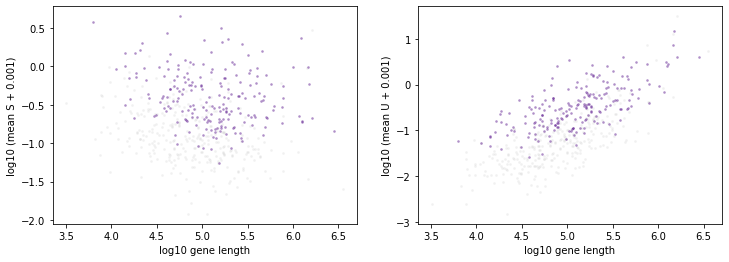

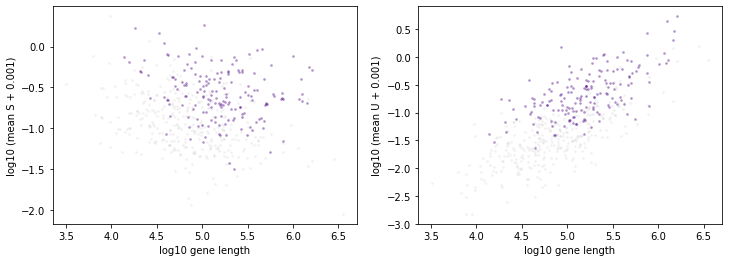

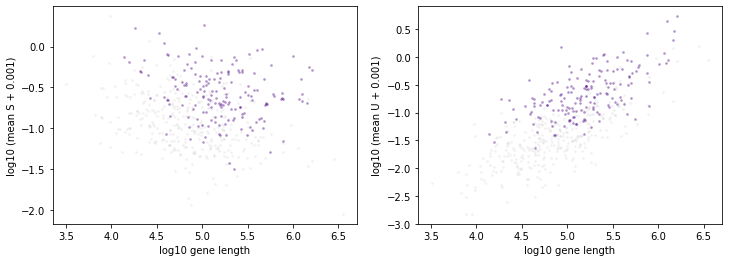

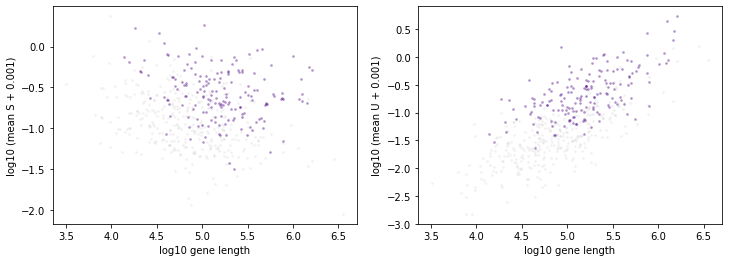

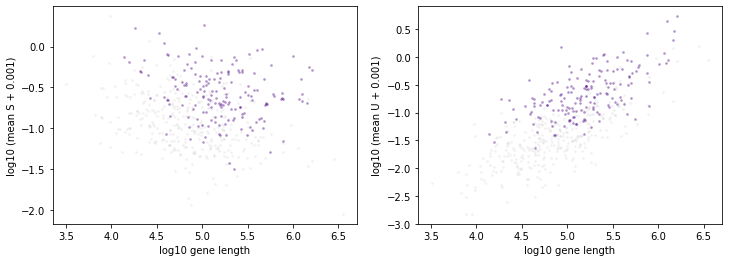

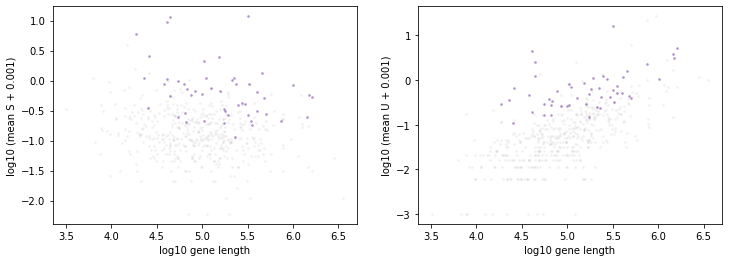

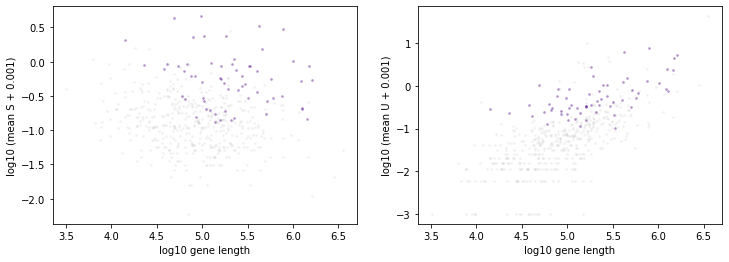

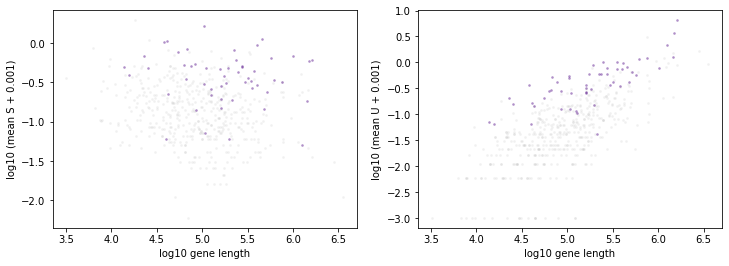

In [1029]:
dir_string,dataset_strings = monod.preprocess.construct_batch(loom_filepaths, \
                                             transcriptome_filepath, \
                                             dataset_names, \
                                             attribute_names=attribute_names,\
                                             batch_location='./fits',meta='simTests_edgecase_MM',batch_id=1,\
                                             datestring='230505', n_genes=n_genes,exp_filter_threshold=None,cf=cf) #230411

In [23]:
dir_string = './fits/gg_230505_025_simTests_edgecase_MM_1'
dataset_strings = [ dir_string+'/'+item for item in dataset_names]
print(dataset_strings)

['./fits/gg_230505_025_simTests_edgecase_MM_1/beta80_sim_k10_k1', './fits/gg_230505_025_simTests_edgecase_MM_1/beta80_sim_k10_k5', './fits/gg_230505_025_simTests_edgecase_MM_1/beta80_sim_k10_k10', './fits/gg_230505_025_simTests_edgecase_MM_1/beta80_sim_k10_k15', './fits/gg_230505_025_simTests_edgecase_MM_1/all90_sim_k10_k1', './fits/gg_230505_025_simTests_edgecase_MM_1/all90_sim_k10_k5', './fits/gg_230505_025_simTests_edgecase_MM_1/all90_sim_k10_k10', './fits/gg_230505_025_simTests_edgecase_MM_1/all90_sim_k10_k15', './fits/gg_230505_025_simTests_edgecase_MM_1/oneClus_beta80_sim_k10_k1', './fits/gg_230505_025_simTests_edgecase_MM_1/oneClus_beta80_sim_k10_k2_k1', './fits/gg_230505_025_simTests_edgecase_MM_1/oneClus_all90_sim_k10_k1']


In [24]:
len(dataset_strings)

11

**Control test with standard Monod fit on the single clusters**

INFO:root:Directory ./fits/gg_230505_025_simTests_edgecase_MM_1/oneClus_beta80_sim_k10_k1/Bursty_Poisson_1x1 already exists.
INFO:root:Global inference parameters stored to ./fits/gg_230505_025_simTests_edgecase_MM_1/oneClus_beta80_sim_k10_k1/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: oneClus_beta80_sim_k10_k1
INFO:root:500 features observed, 500 match genome annotations. 500 were unique.
INFO:root:Gene list extracted from ./fits/gg_230505_025_simTests_edgecase_MM_1/genes.csv.
INFO:root:Directory ./fits/gg_230505_025_simTests_edgecase_MM_1/oneClus_beta80_sim_k10_k1/diagnostic_figures already exists.
INFO:root:Search data stored to ./fits/gg_230505_025_simTests_edgecase_MM_1/oneClus_beta80_sim_k10_k1/raw.sd.
INFO:root:Starting parallelized grid scan.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:21<00:00, 21.09s/it]


INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_230505_025_simTests_edgecase_MM_1/oneClus_beta80_sim_k10_k1/Bursty_Poisson_1x1/analysis_figures already exists.
INFO:root:Runtime: 22.5 seconds.
INFO:root:Directory ./fits/gg_230505_025_simTests_edgecase_MM_1/oneClus_beta80_sim_k10_k2_k1/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230505_025_simTests_edgecase_MM_1/oneClus_beta80_sim_k10_k2_k1/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: oneClus_beta80_sim_k10_k2_k1
INFO:root:500 features observed, 500 match genome annotations. 500 were unique.
INFO:root:Gene list extracted from ./fits/gg_230505_025_simTests_edgecase_MM_1/genes.csv.
INFO:root:Directory ./fits/gg_230505_025_simTests_edgecase_MM_1/oneClus_beta80_sim_k10_k2_k1/diagnostic_figures created.
INFO:root:Search data stored to ./fits/gg_230505_025_simTests_edgecase_MM_1/oneCl

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:23<00:00, 23.15s/it]

INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_230505_025_simTests_edgecase_MM_1/oneClus_beta80_sim_k10_k2_k1/Bursty_Poisson_1x1/analysis_figures created.
INFO:root:Runtime: 24.6 seconds.
INFO:root:Directory ./fits/gg_230505_025_simTests_edgecase_MM_1/oneClus_all90_sim_k10_k1/Bursty_Poisson_1x1 already exists.


INFO:root:Global inference parameters stored to ./fits/gg_230505_025_simTests_edgecase_MM_1/oneClus_all90_sim_k10_k1/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: oneClus_all90_sim_k10_k1
INFO:root:500 features observed, 500 match genome annotations. 500 were unique.
INFO:root:Gene list extracted from ./fits/gg_230505_025_simTests_edgecase_MM_1/genes.csv.
INFO:root:Directory ./fits/gg_230505_025_simTests_edgecase_MM_1/oneClus_all90_sim_k10_k1/diagnostic_figures already exists.
INFO:root:Search data stored to ./fits/gg_230505_025_simTests_edgecase_MM_1/oneClus_all90_sim_k10_k1/raw.sd.
INFO:root:Starting parallelized grid scan.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:20<00:00, 20.86s/it]

INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_230505_025_simTests_edgecase_MM_1/oneClus_all90_sim_k10_k1/Bursty_Poisson_1x1/analysis_figures already exists.
INFO:root:Runtime: 22.3 seconds.


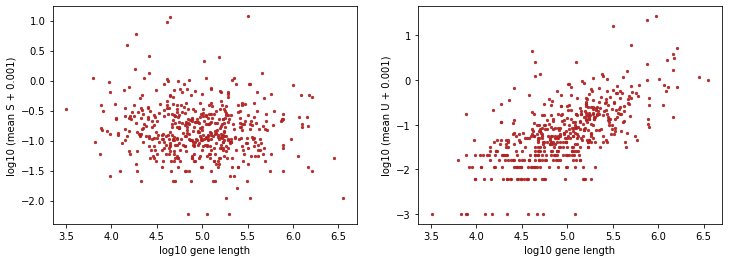

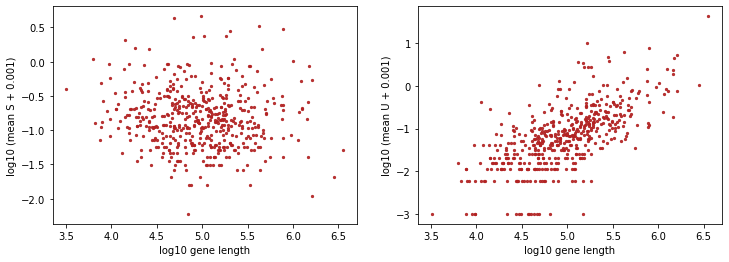

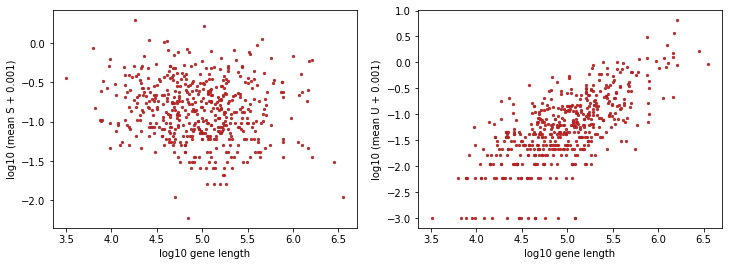

In [1031]:
#Control test with standard Monod fit on first, known cluster of cells
result_strings = []
#for i in range(1,2): #n_datasets
for i in range(len(ks)-3,len(ks)):

    fitmodel = monod.cme_toolbox.CMEModel('Bursty','Poisson')

    inference_parameters = monod.inference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
                dataset_strings[i],fitmodel,use_lengths = True,
                gradient_params = {'max_iterations':20,'init_pattern':'moments','num_restarts':1})

    search_data = monod.extract_data.extract_data(loom_filepaths[i], transcriptome_filepath, dataset_names[i],
                dataset_strings[i], dir_string, dataset_attr_names=attribute_names,cf=cf[i])

    full_result_string = inference_parameters.fit_all_grid_points(30,search_data)

    result_strings.append(full_result_string)

In [62]:
result_strings = [i+'/Bursty_Poisson_1x1/grid_scan_results.res' for i in dataset_strings[(len(dataset_names)-3):]]


In [63]:
sr = [monod.analysis.load_search_results(i) for i in result_strings]
sr

INFO:root:Grid scan results loaded from ./fits/gg_230505_025_simTests_edgecase_MM_1/oneClus_beta80_sim_k10_k1/Bursty_Poisson_1x1/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/gg_230505_025_simTests_edgecase_MM_1/oneClus_beta80_sim_k10_k2_k1/Bursty_Poisson_1x1/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/gg_230505_025_simTests_edgecase_MM_1/oneClus_all90_sim_k10_k1/Bursty_Poisson_1x1/grid_scan_results.res.


**Run meK-Means**


In [741]:
epochs=20

In [742]:
dataset_names

['beta80_sim_k10_k1',
 'beta80_sim_k10_k5',
 'beta80_sim_k10_k10',
 'beta80_sim_k10_k15',
 'all90_sim_k10_k1',
 'all90_sim_k10_k5',
 'all90_sim_k10_k10',
 'all90_sim_k10_k15',
 'oneClus_beta80_sim_k10_k1',
 'oneClus_all90_sim_k10_k1']

In [743]:
result_strings = []
for i in range(4): #Just fitting on beta80 sims for now
    
    fitmodel = monod.cme_toolbox.CMEModel('Bursty','Poisson')
    
    inference_parameters = monod.mminference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
                dataset_strings[i],fitmodel,k=ks[i],epochs=epochs,use_lengths = True,
                gradient_params = {'max_iterations':20,'init_pattern':'moments','num_restarts':1})
    
    search_data = monod.extract_data.extract_data(loom_filepaths[i], transcriptome_filepath, dataset_names[i],
                dataset_strings[i], dir_string, viz=False, dataset_attr_names=attribute_names,cf=cf[i])
    
    inference_parameters.fit_all_grid_points(50,search_data)


INFO:root:Directory ./fits/gg_230505_025_simTests_edgecase_MM_1/beta80_sim_k10_k1/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230505_025_simTests_edgecase_MM_1/beta80_sim_k10_k1/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: beta80_sim_k10_k1
INFO:root:500 features observed, 500 match genome annotations. 500 were unique.
INFO:root:Gene list extracted from ./fits/gg_230505_025_simTests_edgecase_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230505_025_simTests_edgecase_MM_1/beta80_sim_k10_k1/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:49<00:00, 109.22s/it]


INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:49<00:00, 109.17s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -1021304.9200214393

INFO:root:EM Epoch 2/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:47<00:00, 107.75s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -1021304.9200214393

INFO:root:EM Epoch 3/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:48<00:00, 108.52s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -1021304.9200214393

INFO:root:EM Epoch 4/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:48<00:00, 108.81s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -1021304.9200214393

INFO:root:EM Epoch 5/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:48<00:00, 108.70s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -1021304.9200214393

INFO:root:EM Epoch 6/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:49<00:00, 109.44s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -1021304.9200214393

INFO:root:EM Epoch 7/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:48<00:00, 108.50s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -1021304.9200214393

INFO:root:EM Epoch 8/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:47<00:00, 107.57s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -1021304.9200214393

INFO:root:EM Epoch 9/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:49<00:00, 109.42s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -1021304.9200214393

INFO:root:EM Epoch 10/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:47<00:00, 107.58s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -1021304.9200214393

INFO:root:EM Epoch 11/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:48<00:00, 108.61s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -1021304.9200214393

INFO:root:EM Epoch 12/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:48<00:00, 108.00s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -1021304.9200214393

INFO:root:EM Epoch 13/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:49<00:00, 109.57s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -1021304.9200214393

INFO:root:EM Epoch 14/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:50<00:00, 110.30s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -1021304.9200214393

INFO:root:EM Epoch 15/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:49<00:00, 109.19s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -1021304.9200214393

INFO:root:EM Epoch 16/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:49<00:00, 109.42s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -1021304.9200214393

INFO:root:EM Epoch 17/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:49<00:00, 109.95s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -1021304.9200214393

INFO:root:EM Epoch 18/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:49<00:00, 109.29s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -1021304.9200214393

INFO:root:EM Epoch 19/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:50<00:00, 110.18s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -1021304.9200214393

INFO:root:EM Epoch 20/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:49<00:00, 109.28s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -1021304.9200214393

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230505_025_simTests_edgecase_MM_1/beta80_sim_k10_k5/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230505_025_simTests_edgecase_MM_1/beta80_sim_k10_k5/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: beta80_sim_k10_k5
INFO:root:500 features observed, 500 match genome annotations. 500 were unique.
INFO:root:Gene list extracted from ./fits/gg_230505_025_simTests_edgecase_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230505_025_simTests_edgecase_MM_1/beta80_sim_k10_k5/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:28<00:00, 17.79s/it]


INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:10<00:00, 14.00s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.20486933 0.1027108  0.47308576 0.11172064 0.10761347]
Q Function:  -996140.035686091

INFO:root:EM Epoch 2/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:09<00:00, 13.84s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.2 0.1 0.5 0.1 0.1]
Q Function:  -982722.3953170481

INFO:root:EM Epoch 3/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:09<00:00, 13.83s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.2 0.1 0.5 0.1 0.1]
Q Function:  -985186.7105750296

INFO:root:EM Epoch 4/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:08<00:00, 13.73s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.2 0.1 0.5 0.1 0.1]
Q Function:  -985186.7105750296

INFO:root:EM Epoch 5/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:08<00:00, 13.72s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.2 0.1 0.5 0.1 0.1]
Q Function:  -985186.7105750296

INFO:root:EM Epoch 6/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:08<00:00, 13.61s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.2 0.1 0.5 0.1 0.1]
Q Function:  -985186.7105750296

INFO:root:EM Epoch 7/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:08<00:00, 13.65s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.2 0.1 0.5 0.1 0.1]
Q Function:  -985186.7105750296

INFO:root:EM Epoch 8/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:08<00:00, 13.64s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.2 0.1 0.5 0.1 0.1]
Q Function:  -985186.7105750296

INFO:root:EM Epoch 9/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:08<00:00, 13.73s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.2 0.1 0.5 0.1 0.1]
Q Function:  -985186.7105750296

INFO:root:EM Epoch 10/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:08<00:00, 13.70s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.2 0.1 0.5 0.1 0.1]
Q Function:  -985186.7105750296

INFO:root:EM Epoch 11/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:08<00:00, 13.72s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.2 0.1 0.5 0.1 0.1]
Q Function:  -985186.7105750296

INFO:root:EM Epoch 12/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:07<00:00, 13.56s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.2 0.1 0.5 0.1 0.1]
Q Function:  -985186.7105750296

INFO:root:EM Epoch 13/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:08<00:00, 13.60s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.2 0.1 0.5 0.1 0.1]
Q Function:  -985186.7105750296

INFO:root:EM Epoch 14/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:08<00:00, 13.74s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.2 0.1 0.5 0.1 0.1]
Q Function:  -985186.7105750296

INFO:root:EM Epoch 15/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:07<00:00, 13.56s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.2 0.1 0.5 0.1 0.1]
Q Function:  -985186.7105750296

INFO:root:EM Epoch 16/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:08<00:00, 13.72s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.2 0.1 0.5 0.1 0.1]
Q Function:  -985186.7105750296

INFO:root:EM Epoch 17/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:08<00:00, 13.64s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.2 0.1 0.5 0.1 0.1]
Q Function:  -985186.7105750296

INFO:root:EM Epoch 18/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:08<00:00, 13.67s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.2 0.1 0.5 0.1 0.1]
Q Function:  -985186.7105750296

INFO:root:EM Epoch 19/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:14<00:00, 14.82s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.2 0.1 0.5 0.1 0.1]
Q Function:  -985186.7105750296

INFO:root:EM Epoch 20/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:08<00:00, 13.61s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.2 0.1 0.5 0.1 0.1]
Q Function:  -985186.7105750296

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230505_025_simTests_edgecase_MM_1/beta80_sim_k10_k10/Bursty_Poisson_1x1 already exists.
INFO:root:Global inference parameters stored to ./fits/gg_230505_025_simTests_edgecase_MM_1/beta80_sim_k10_k10/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: beta80_sim_k10_k10
INFO:root:500 features observed, 500 match genome annotations. 500 were unique.
INFO:root:Gene list extracted from ./fits/gg_230505_025_simTests_edgecase_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230505_025_simTests_edgecase_MM_1/beta80_sim_k10_k10/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:28<00:00,  8.83s/it]


INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:02<00:00,  6.29s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.10443052 0.09131156 0.11820697 0.10328278 0.10327776 0.1021869
 0.09826528 0.10464678 0.09831311 0.07607834]
Q Function:  -1003228.8948411592

INFO:root:EM Epoch 2/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:57<00:00,  5.78s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.1        0.1        0.10106489 0.1        0.1004987  0.1
 0.0995013  0.1        0.09992765 0.09900745]
Q Function:  -964274.6711353671

INFO:root:EM Epoch 3/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:59<00:00,  5.92s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Q Function:  -958077.1516563131

INFO:root:EM Epoch 4/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:57<00:00,  5.76s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Q Function:  -958806.2777813354

INFO:root:EM Epoch 5/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:57<00:00,  5.73s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Q Function:  -958806.2777813354

INFO:root:EM Epoch 6/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:58<00:00,  5.87s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Q Function:  -958806.2777813354

INFO:root:EM Epoch 7/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:57<00:00,  5.78s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Q Function:  -958806.2777813354

INFO:root:EM Epoch 8/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:57<00:00,  5.78s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Q Function:  -958806.2777813354

INFO:root:EM Epoch 9/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:56<00:00,  5.70s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Q Function:  -958806.2777813354

INFO:root:EM Epoch 10/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:57<00:00,  5.76s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Q Function:  -958806.2777813354

INFO:root:EM Epoch 11/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:57<00:00,  5.75s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Q Function:  -958806.2777813354

INFO:root:EM Epoch 12/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:57<00:00,  5.75s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Q Function:  -958806.2777813354

INFO:root:EM Epoch 13/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:58<00:00,  5.83s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Q Function:  -958806.2777813354

INFO:root:EM Epoch 14/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:58<00:00,  5.84s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Q Function:  -958806.2777813354

INFO:root:EM Epoch 15/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:57<00:00,  5.80s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Q Function:  -958806.2777813354

INFO:root:EM Epoch 16/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:57<00:00,  5.78s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Q Function:  -958806.2777813354

INFO:root:EM Epoch 17/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:58<00:00,  5.81s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Q Function:  -958806.2777813354

INFO:root:EM Epoch 18/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:58<00:00,  5.83s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Q Function:  -958806.2777813354

INFO:root:EM Epoch 19/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:57<00:00,  5.76s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Q Function:  -958806.2777813354

INFO:root:EM Epoch 20/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:57<00:00,  5.77s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Q Function:  -958806.2777813354

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230505_025_simTests_edgecase_MM_1/beta80_sim_k10_k15/Bursty_Poisson_1x1 already exists.
INFO:root:Global inference parameters stored to ./fits/gg_230505_025_simTests_edgecase_MM_1/beta80_sim_k10_k15/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: beta80_sim_k10_k15
INFO:root:500 features observed, 500 match genome annotations. 500 were unique.
INFO:root:Gene list extracted from ./fits/gg_230505_025_simTests_edgecase_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230505_025_simTests_edgecase_MM_1/beta80_sim_k10_k15/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [01:40<00:00,  6.70s/it]


INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [01:31<00:00,  6.09s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.0471828  0.14001397 0.01751234 0.07179477 0.00132435 0.07526284
 0.02439114 0.06326169 0.0387671  0.09098625 0.1540133  0.10185157
 0.06030319 0.10268323 0.01065145]
Q Function:  -1018956.3102094224

INFO:root:EM Epoch 2/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:58<00:00,  4.85s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [4.57138943e-02 1.20173298e-01 5.00000017e-10 9.34161576e-02
 4.99999996e-10 9.95010929e-02 8.87777738e-03 9.42328066e-02
 3.39739452e-02 1.00000095e-01 1.23839897e-01 9.99999996e-02
 8.07708935e-02 9.95001407e-02 4.99999996e-10]
Q Function:  -975598.5966512396

INFO:root:EM Epoch 3/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [01:02<00:00,  5.67s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [2.42218200e-02 1.74301762e-01 4.99999996e-10 9.89999239e-02
 4.99999996e-10 9.99999997e-02 5.00049831e-10 9.99999997e-02
 1.47687977e-03 9.99999997e-02 1.07392802e-01 9.99999997e-02
 9.36068116e-02 9.99999997e-02 4.99999996e-10]
Q Function:  -984017.311327874

INFO:root:EM Epoch 4/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:57<00:00,  6.38s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [5.03054347e-10 1.99999999e-01 4.99999996e-10 9.99999998e-02
 4.99999996e-10 9.99999998e-02 4.99999996e-10 9.99999998e-02
 4.99999996e-10 9.99999998e-02 9.99999998e-02 9.99999998e-02
 9.99999997e-02 9.99999998e-02 4.99999996e-10]
Q Function:  -971741.1864013104

INFO:root:EM Epoch 5/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:57<00:00,  6.43s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [4.99999996e-10 1.99999999e-01 4.99999996e-10 9.99999998e-02
 4.99999996e-10 9.99999998e-02 4.99999996e-10 9.99999998e-02
 4.99999996e-10 9.99999998e-02 9.99999998e-02 9.99999998e-02
 9.99999998e-02 9.99999997e-02 4.99999996e-10]
Q Function:  -967043.7577587512

INFO:root:EM Epoch 6/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:57<00:00,  6.36s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [4.99999996e-10 1.99999999e-01 4.99999996e-10 9.99999998e-02
 4.99999996e-10 9.99999998e-02 4.99999996e-10 9.99999998e-02
 4.99999996e-10 9.99999998e-02 9.99999998e-02 9.99999998e-02
 9.99999998e-02 9.99999997e-02 4.99999996e-10]
Q Function:  -967043.7577587452

INFO:root:EM Epoch 7/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:57<00:00,  6.38s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [4.99999996e-10 1.99999999e-01 4.99999996e-10 9.99999998e-02
 4.99999996e-10 9.99999998e-02 4.99999996e-10 9.99999998e-02
 4.99999996e-10 9.99999998e-02 9.99999998e-02 9.99999998e-02
 9.99999998e-02 9.99999997e-02 4.99999996e-10]
Q Function:  -967043.7577587452

INFO:root:EM Epoch 8/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:57<00:00,  6.42s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [4.99999996e-10 1.99999999e-01 4.99999996e-10 9.99999998e-02
 4.99999996e-10 9.99999998e-02 4.99999996e-10 9.99999998e-02
 4.99999996e-10 9.99999998e-02 9.99999998e-02 9.99999998e-02
 9.99999998e-02 9.99999997e-02 4.99999996e-10]
Q Function:  -967043.7577587452

INFO:root:EM Epoch 9/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:58<00:00,  6.55s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [4.99999996e-10 1.99999999e-01 4.99999996e-10 9.99999998e-02
 4.99999996e-10 9.99999998e-02 4.99999996e-10 9.99999998e-02
 4.99999996e-10 9.99999998e-02 9.99999998e-02 9.99999998e-02
 9.99999998e-02 9.99999997e-02 4.99999996e-10]
Q Function:  -967043.7577587452

INFO:root:EM Epoch 10/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:57<00:00,  6.41s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [4.99999996e-10 1.99999999e-01 4.99999996e-10 9.99999998e-02
 4.99999996e-10 9.99999998e-02 4.99999996e-10 9.99999998e-02
 4.99999996e-10 9.99999998e-02 9.99999998e-02 9.99999998e-02
 9.99999998e-02 9.99999997e-02 4.99999996e-10]
Q Function:  -967043.7577587452

INFO:root:EM Epoch 11/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:57<00:00,  6.38s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [4.99999996e-10 1.99999999e-01 4.99999996e-10 9.99999998e-02
 4.99999996e-10 9.99999998e-02 4.99999996e-10 9.99999998e-02
 4.99999996e-10 9.99999998e-02 9.99999998e-02 9.99999998e-02
 9.99999998e-02 9.99999997e-02 4.99999996e-10]
Q Function:  -967043.7577587452

INFO:root:EM Epoch 12/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:56<00:00,  6.30s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [4.99999996e-10 1.99999999e-01 4.99999996e-10 9.99999998e-02
 4.99999996e-10 9.99999998e-02 4.99999996e-10 9.99999998e-02
 4.99999996e-10 9.99999998e-02 9.99999998e-02 9.99999998e-02
 9.99999998e-02 9.99999997e-02 4.99999996e-10]
Q Function:  -967043.7577587452

INFO:root:EM Epoch 13/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:56<00:00,  6.32s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [4.99999996e-10 1.99999999e-01 4.99999996e-10 9.99999998e-02
 4.99999996e-10 9.99999998e-02 4.99999996e-10 9.99999998e-02
 4.99999996e-10 9.99999998e-02 9.99999998e-02 9.99999998e-02
 9.99999998e-02 9.99999997e-02 4.99999996e-10]
Q Function:  -967043.7577587452

INFO:root:EM Epoch 14/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:56<00:00,  6.32s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [4.99999996e-10 1.99999999e-01 4.99999996e-10 9.99999998e-02
 4.99999996e-10 9.99999998e-02 4.99999996e-10 9.99999998e-02
 4.99999996e-10 9.99999998e-02 9.99999998e-02 9.99999998e-02
 9.99999998e-02 9.99999997e-02 4.99999996e-10]
Q Function:  -967043.7577587452

INFO:root:EM Epoch 15/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:57<00:00,  6.35s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [4.99999996e-10 1.99999999e-01 4.99999996e-10 9.99999998e-02
 4.99999996e-10 9.99999998e-02 4.99999996e-10 9.99999998e-02
 4.99999996e-10 9.99999998e-02 9.99999998e-02 9.99999998e-02
 9.99999998e-02 9.99999997e-02 4.99999996e-10]
Q Function:  -967043.7577587452

INFO:root:EM Epoch 16/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:57<00:00,  6.38s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [4.99999996e-10 1.99999999e-01 4.99999996e-10 9.99999998e-02
 4.99999996e-10 9.99999998e-02 4.99999996e-10 9.99999998e-02
 4.99999996e-10 9.99999998e-02 9.99999998e-02 9.99999998e-02
 9.99999998e-02 9.99999997e-02 4.99999996e-10]
Q Function:  -967043.7577587452

INFO:root:EM Epoch 17/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:57<00:00,  6.36s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [4.99999996e-10 1.99999999e-01 4.99999996e-10 9.99999998e-02
 4.99999996e-10 9.99999998e-02 4.99999996e-10 9.99999998e-02
 4.99999996e-10 9.99999998e-02 9.99999998e-02 9.99999998e-02
 9.99999998e-02 9.99999997e-02 4.99999996e-10]
Q Function:  -967043.7577587452

INFO:root:EM Epoch 18/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:57<00:00,  6.34s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [4.99999996e-10 1.99999999e-01 4.99999996e-10 9.99999998e-02
 4.99999996e-10 9.99999998e-02 4.99999996e-10 9.99999998e-02
 4.99999996e-10 9.99999998e-02 9.99999998e-02 9.99999998e-02
 9.99999998e-02 9.99999997e-02 4.99999996e-10]
Q Function:  -967043.7577587452

INFO:root:EM Epoch 19/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:57<00:00,  6.38s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [4.99999996e-10 1.99999999e-01 4.99999996e-10 9.99999998e-02
 4.99999996e-10 9.99999998e-02 4.99999996e-10 9.99999998e-02
 4.99999996e-10 9.99999998e-02 9.99999998e-02 9.99999998e-02
 9.99999998e-02 9.99999997e-02 4.99999996e-10]
Q Function:  -967043.7577587452

INFO:root:EM Epoch 20/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:56<00:00,  6.31s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [4.99999996e-10 1.99999999e-01 4.99999996e-10 9.99999998e-02
 4.99999996e-10 9.99999998e-02 4.99999996e-10 9.99999998e-02
 4.99999996e-10 9.99999998e-02 9.99999998e-02 9.99999998e-02
 9.99999998e-02 9.99999997e-02 4.99999996e-10]
Q Function:  -967043.7577587452

INFO:root:Non-parallelized grid scan complete.


**Check k-means and leiden clusters results**

Show k-means results

In [67]:
len(all_assigns)

2000

In [50]:
all_groups_kmeans = []
aris = []
in_type = []
kmeans_k = []
which_data = []



In [51]:
for i in range(len(ks)-3):
    which = i
    search_data = monod.extract_data.extract_data(loom_filepaths[which], transcriptome_filepath, dataset_names[which],
                dataset_strings[which], dir_string, viz=False, dataset_attr_names=attribute_names,cf=cf[which])
    
    S = search_data.layers[1,:,:]
    S_t = S.T
    tots = np.sum(S_t,axis=1)
    divids = (1e4/tots)[:,None]
    S_t = S_t*divids
    S_t = np.log1p(S_t)

    kmeans = KMeans(n_clusters=ks[i], random_state=0).fit(S_t)
    labs = kmeans.labels_
    
    all_groups_kmeans += [labs]

    labels = labs
    
 
    trues = all_assigns
    
    aris += [adjusted_rand_score(labels, trues)]
    in_type += ['S']
    kmeans_k += [ks[i]]
    which_data += [dataset_names[which]]
    

INFO:root:Beginning data extraction.
INFO:root:Dataset: beta80_sim_k10_k1
INFO:root:500 features observed, 500 match genome annotations. 500 were unique.
INFO:root:Gene list extracted from ./fits/gg_230505_025_simTests_edgecase_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230505_025_simTests_edgecase_MM_1/beta80_sim_k10_k1/raw.sd.
INFO:root:Beginning data extraction.
INFO:root:Dataset: beta80_sim_k10_k5
INFO:root:500 features observed, 500 match genome annotations. 500 were unique.
INFO:root:Gene list extracted from ./fits/gg_230505_025_simTests_edgecase_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230505_025_simTests_edgecase_MM_1/beta80_sim_k10_k5/raw.sd.
INFO:root:Beginning data extraction.
INFO:root:Dataset: beta80_sim_k10_k10
INFO:root:500 features observed, 500 match genome annotations. 500 were unique.
INFO:root:Gene list extracted from ./fits/gg_230505_025_simTests_edgecase_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230505_025_simTests_e

In [52]:
for i in range(len(ks)-3):
    which = i
    search_data = monod.extract_data.extract_data(loom_filepaths[which], transcriptome_filepath, dataset_names[which],
                dataset_strings[which], dir_string, viz=False, dataset_attr_names=attribute_names,cf=cf[which])
    
    S = search_data.layers[0,:,:]
    S_t = S.T
    tots = np.sum(S_t,axis=1)
    divids = (1e4/tots)[:,None]
    S_t = S_t*divids
    S_t = np.log1p(S_t)

    kmeans = KMeans(n_clusters=ks[i], random_state=0).fit(S_t)
    labs = kmeans.labels_

    labels = labs
    all_groups_kmeans += [labs]
    
    
    trues = all_assigns
    
    aris += [adjusted_rand_score(labels,trues)]
    in_type += ['U']
    kmeans_k += [ks[i]]
    which_data += [dataset_names[which]]
    
    

INFO:root:Beginning data extraction.
INFO:root:Dataset: beta80_sim_k10_k1
INFO:root:500 features observed, 500 match genome annotations. 500 were unique.
INFO:root:Gene list extracted from ./fits/gg_230505_025_simTests_edgecase_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230505_025_simTests_edgecase_MM_1/beta80_sim_k10_k1/raw.sd.
INFO:root:Beginning data extraction.
INFO:root:Dataset: beta80_sim_k10_k5
INFO:root:500 features observed, 500 match genome annotations. 500 were unique.
INFO:root:Gene list extracted from ./fits/gg_230505_025_simTests_edgecase_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230505_025_simTests_edgecase_MM_1/beta80_sim_k10_k5/raw.sd.
INFO:root:Beginning data extraction.
INFO:root:Dataset: beta80_sim_k10_k10
INFO:root:500 features observed, 500 match genome annotations. 500 were unique.
INFO:root:Gene list extracted from ./fits/gg_230505_025_simTests_edgecase_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230505_025_simTests_e

In [53]:
for i in range(len(ks)-3):
    which = i
    search_data = monod.extract_data.extract_data(loom_filepaths[which], transcriptome_filepath, dataset_names[which],
                dataset_strings[which], dir_string, viz=False, dataset_attr_names=attribute_names,cf=cf[which])
    
    U = search_data.layers[0,:,:]
    U_t = U.T
    S = search_data.layers[1,:,:]
    S_t = S.T
    
    concat = np.concatenate((U_t, S_t), axis=1)

    tots = np.sum(concat,axis=1)
    divids = (1e4/tots)[:,None]
    concat = concat*divids
    concat = np.log1p(concat)

    
    
    kmeans = KMeans(n_clusters=ks[i], random_state=0).fit(concat)
    labs = kmeans.labels_

    labels = labs
    all_groups_kmeans += [labs]
    
    trues = all_assigns
    
    aris += [adjusted_rand_score(labels, trues)]
    in_type += ['U.S']
    kmeans_k += [ks[i]]
    which_data += [dataset_names[which]]
    
    

INFO:root:Beginning data extraction.
INFO:root:Dataset: beta80_sim_k10_k1
INFO:root:500 features observed, 500 match genome annotations. 500 were unique.
INFO:root:Gene list extracted from ./fits/gg_230505_025_simTests_edgecase_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230505_025_simTests_edgecase_MM_1/beta80_sim_k10_k1/raw.sd.
INFO:root:Beginning data extraction.
INFO:root:Dataset: beta80_sim_k10_k5
INFO:root:500 features observed, 500 match genome annotations. 500 were unique.
INFO:root:Gene list extracted from ./fits/gg_230505_025_simTests_edgecase_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230505_025_simTests_edgecase_MM_1/beta80_sim_k10_k5/raw.sd.
INFO:root:Beginning data extraction.
INFO:root:Dataset: beta80_sim_k10_k10
INFO:root:500 features observed, 500 match genome annotations. 500 were unique.
INFO:root:Gene list extracted from ./fits/gg_230505_025_simTests_edgecase_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230505_025_simTests_e

In [54]:
for i in range(len(ks)-3):
    which = i
    search_data = monod.extract_data.extract_data(loom_filepaths[which], transcriptome_filepath, dataset_names[which],
                dataset_strings[which], dir_string, viz=False, dataset_attr_names=attribute_names,cf=cf[which])
    
    U = search_data.layers[0,:,:]
    U_t = U.T
    S = search_data.layers[1,:,:]
    S_t = S.T
    
    concat = U_t+S_t

    tots = np.sum(concat,axis=1)
    divids = (1e4/tots)[:,None]
    concat = concat*divids
    concat = np.log1p(concat)

    
    
    kmeans = KMeans(n_clusters=ks[i], random_state=0).fit(concat)
    labs = kmeans.labels_

    labels = labs
    all_groups_kmeans += [labs]
    
    trues = all_assigns
    
    aris += [adjusted_rand_score(labels, trues)]
    in_type += ['U+S']
    kmeans_k += [ks[i]]
    which_data += [dataset_names[which]]
    
    

INFO:root:Beginning data extraction.
INFO:root:Dataset: beta80_sim_k10_k1
INFO:root:500 features observed, 500 match genome annotations. 500 were unique.
INFO:root:Gene list extracted from ./fits/gg_230505_025_simTests_edgecase_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230505_025_simTests_edgecase_MM_1/beta80_sim_k10_k1/raw.sd.
INFO:root:Beginning data extraction.
INFO:root:Dataset: beta80_sim_k10_k5
INFO:root:500 features observed, 500 match genome annotations. 500 were unique.
INFO:root:Gene list extracted from ./fits/gg_230505_025_simTests_edgecase_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230505_025_simTests_edgecase_MM_1/beta80_sim_k10_k5/raw.sd.
INFO:root:Beginning data extraction.
INFO:root:Dataset: beta80_sim_k10_k10
INFO:root:500 features observed, 500 match genome annotations. 500 were unique.
INFO:root:Gene list extracted from ./fits/gg_230505_025_simTests_edgecase_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230505_025_simTests_e

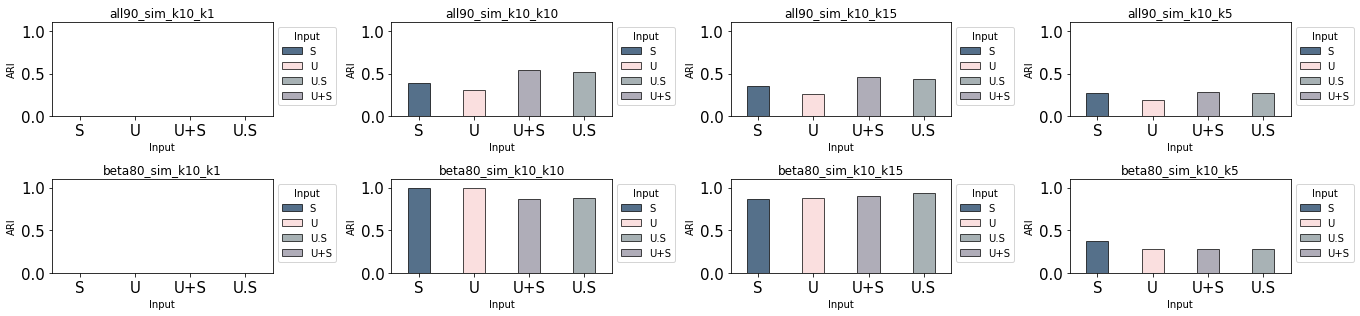

In [55]:
#Make plots of ARI scores for every K-Means run

aris_df = pd.DataFrame()
aris_df['ARI'] = aris
aris_df['Input'] = in_type
aris_df['K'] = kmeans_k
aris_df['Dataset'] = which_data

palette={'S':'#003366','U':'#FFCCCC', 'U+S':'#8c879e','U.S':'#809499'}

num_cols = len(np.unique(aris_df['K']))
fig, ax = plt.subplots(nrows=int(len(np.unique(which_data))/num_cols), ncols=num_cols, figsize=(19,4.5))

for i in range(len(np.unique(which_data))):
    select = np.unique(which_data)[i]
    sub_ari = aris_df[aris_df.Dataset == select]


    g = sns.barplot(data=sub_ari,x='Input',y='ARI',order=['S','U','U+S','U.S'],
                        hue='Input',palette=palette,edgecolor='black',ax=ax[int(i/num_cols),i%num_cols],
                   alpha=0.7,dodge=False)
    sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
    
    for bar in g.patches:
        x = bar.get_x()
        width = bar.get_width()
        centre = x+width/2.
        newwidth = width/2

        bar.set_x(centre-newwidth/2.)
        bar.set_width(newwidth)

    ax[int(i/num_cols),i%num_cols].set_title(select)
    ax[int(i/num_cols),i%num_cols].set_ylim((0,1.1))
    
    ax[int(i/num_cols),i%num_cols].tick_params(axis='both', which='major', labelsize=15)
    ax[int(i/num_cols),i%num_cols].tick_params(axis='both', which='minor', labelsize=15)
    
plt.tight_layout()
plt.savefig('ari_sim10.pdf')


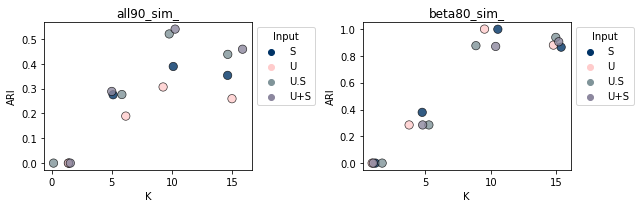

In [56]:
#Make summary ARI plots for each simulation dataset
aris_df['Data_noK'] = [i[0:i.index('k10')] for i in aris_df['Dataset']]


fig, ax = plt.subplots(ncols=int(len(np.unique(which_data))/num_cols), figsize=(9,3))

for i in range(len(np.unique(aris_df['Data_noK']))):
    select = np.unique(aris_df['Data_noK'])[i]
    sub_ari = aris_df[aris_df.Data_noK == select]
    g=sns.scatterplot(data=sub_ari,x=sub_ari.K+np.random.normal(0,0.5,len(sub_ari.K)),
                      y='ARI',hue='Input',palette=palette,
                    s=70,edgecolor='black',alpha=0.8,ax=ax[i])
    ax[i].set_title(select)
    sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
    
plt.tight_layout()
plt.savefig('ari_sim10_summary.pdf')


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see ht

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see ht

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see ht

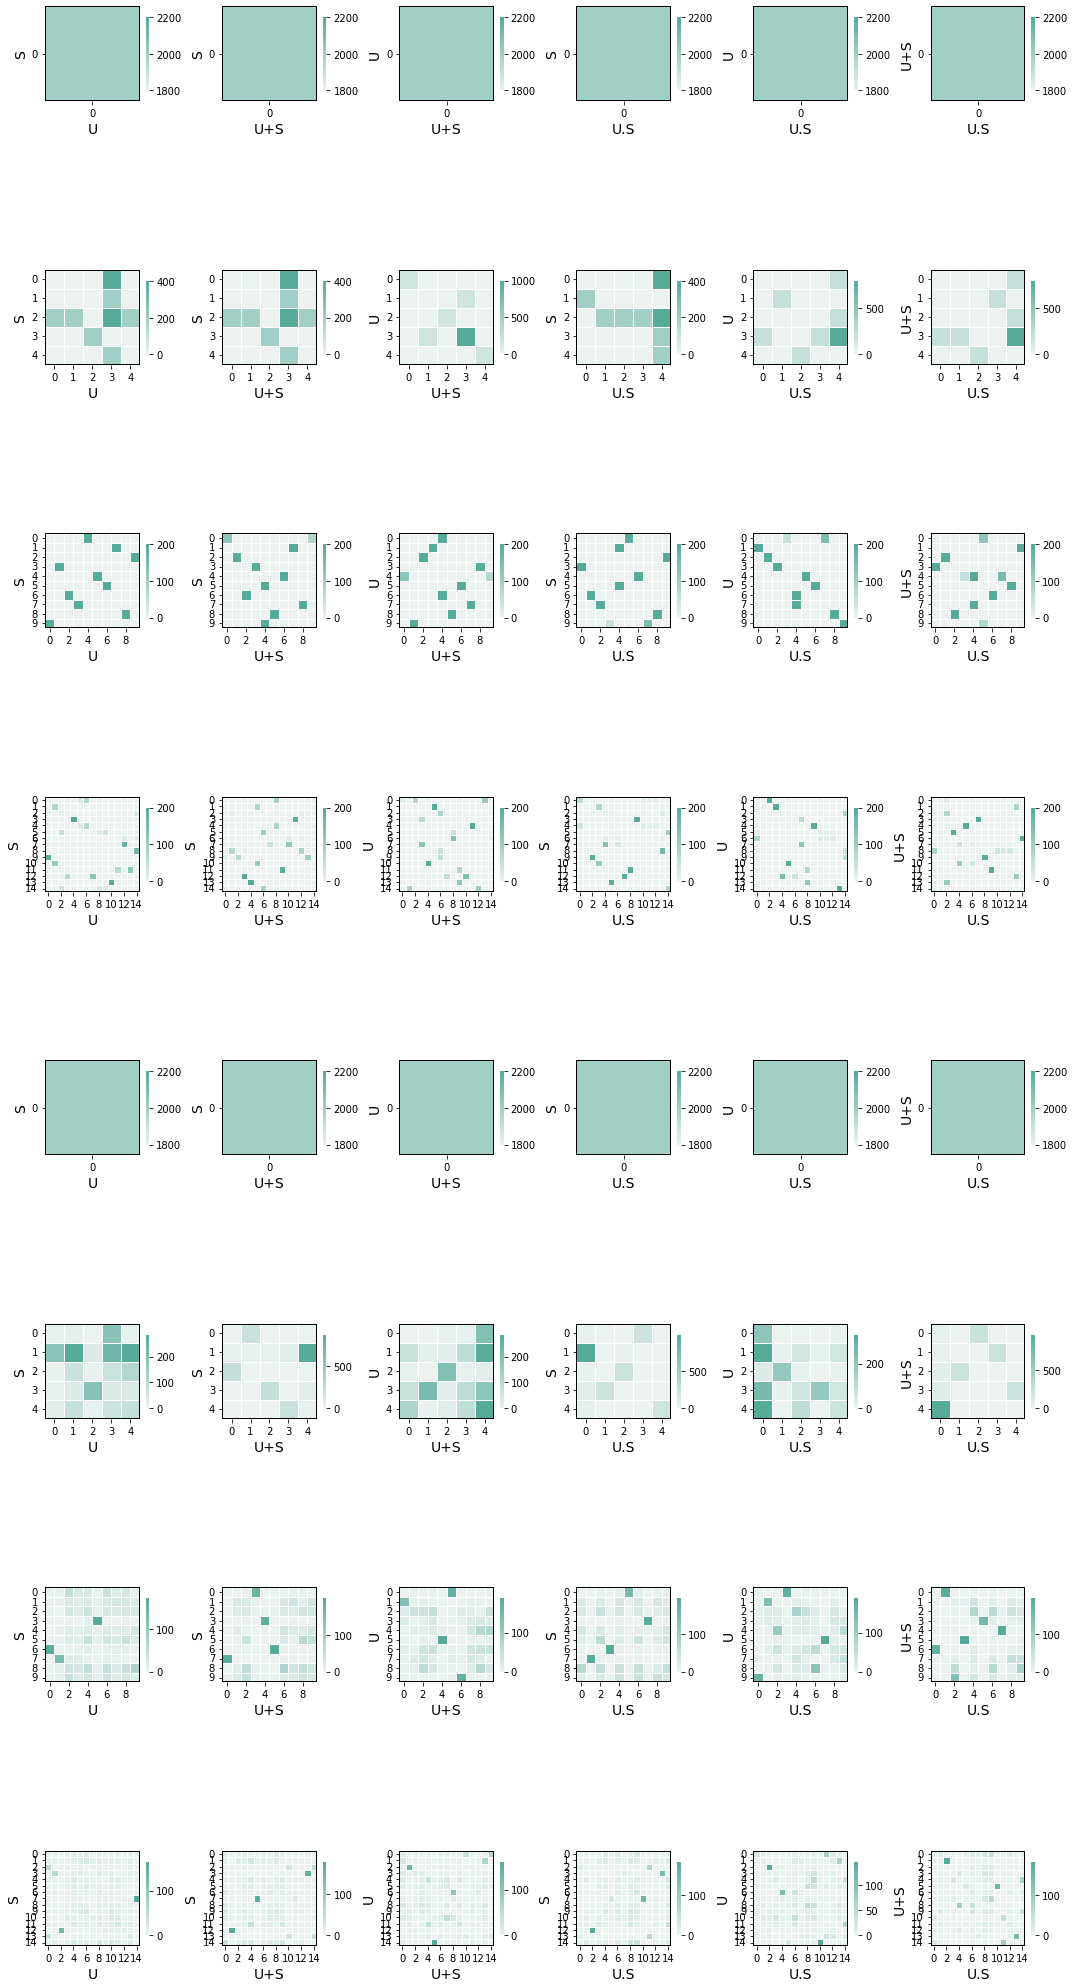

In [217]:
#Compare overlap/concordance of all k-means assignments (S v U,S v U+S,U v U+S)

num_per_set = len(ks)-3

pairs = [(0,1),(0,3),(1,3),(0,2),(1,2),(3,2)]
labs = [('S','U'),('S','U+S'),('U','U+S'),('S','U.S'),('U','U.S'),('U+S','U.S')]
#Plot confmats
fig, ax = plt.subplots(nrows=num_per_set, ncols=len(pairs), figsize=(15,30))
    
for i in range(0,num_per_set):
    
    for j in range(len(pairs)):
        
        p = pairs[j]
        
        assign = all_groups_kmeans[p[1]*(num_per_set)+i]
        true = all_groups_kmeans[p[0]*(num_per_set)+i]

        true_copy = list(true)
        assign_copy = list(assign)

        if np.max(assign) > np.max(true): #FIX
            for a in np.unique(assign):
                if a > np.max(true):
                    true_copy += [a]
                    assign_copy += [a]


        conmat = confusion_matrix(true_copy, assign_copy)
        val = np.mat(conmat) 
        classnames = list(set(true_copy))
        df_cm = pd.DataFrame(

                val, index=classnames, columns=classnames, 

            )


        if np.max(assign) > np.max(true): #FIX
            for a in np.unique(assign):
                if a > np.max(true):
                    print(df_cm.shape)
                    df_cm.loc[a,a] = df_cm.loc[a,a]-1


        heatmap = sns.heatmap(df_cm, annot=False, 
                              cmap=sns.color_palette("light:#5A9", as_cmap=True),ax=ax[i,j],
                             square=True,linewidths=1, cbar_kws={"shrink": 0.25})
        heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
        heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0)
        
        heatmap.axhline(y=0, color='k',linewidth=2)
        heatmap.axhline(y=val.shape[1], color='k',linewidth=2)
        heatmap.axvline(x=0, color='k',linewidth=2)
        heatmap.axvline(x=val.shape[0], color='k',linewidth=2)

        ax[i,j].set_ylabel(labs[j][0],fontsize=14)
        ax[i,j].set_xlabel(labs[j][1],fontsize=14)
        
        ax[i,j].tick_params(axis='both', which='minor', labelsize=10,)
        ax[i,j].tick_params(axis='both', which='major', labelsize=10)
        #ax[i,j].tick_params(axis='x',labelrotation=-90)


plt.tight_layout()  
#plt.show()
plt.savefig('kmeans_conf_sim10.pdf')
    

In [218]:
dataset_meta

['beta80_sim_k10',
 'beta80_sim_k10',
 'beta80_sim_k10',
 'beta80_sim_k10',
 'all90_sim_k10',
 'all90_sim_k10',
 'all90_sim_k10',
 'all90_sim_k10',
 'oneClus_beta80_sim_k10',
 'oneClus_beta80_sim_k10_k2',
 'oneClus_all90_sim_k10']

Show leiden clusters

In [60]:
neigh = 30
all_groups = []
res = [0.25,0.5,1.0,2.0]*len(out_names)

aris = []
in_type = []
kmeans_k = []
which_data = []


In [61]:
#From https://github.com/scverse/scanpy/blob/ed3b277b2f498e3cab04c9416aaddf97eec8c3e2/scanpy/tools/_leiden.py#L24-L177
for i in range(len(ks)-3):
    which = i
    search_data = monod.extract_data.extract_data(loom_filepaths[which], transcriptome_filepath, dataset_names[which],
                dataset_strings[which], dir_string, viz=False, dataset_attr_names=attribute_names,cf=cf[which])
    #Spliced
    S = search_data.layers[1,:,:]
    S_t = S.T
    tots = np.sum(S_t,axis=1)
    divids = (1e4/tots)[:,None]
    S_t = S_t*divids
    S_t = np.log1p(S_t)

    A = kneighbors_graph(S_t, neigh, mode='connectivity', include_self=True)
    sources, targets = A.nonzero()
    weights = A[sources, targets]
    if isinstance(weights, np.matrix):
        weights = weights.A1
    g = ig.Graph(directed=False) #True in scanpy, which is odd
    g.add_vertices(A.shape[0])  # this adds adjacency.shape[0] vertices
    g.add_edges(list(zip(sources, targets)))

    g.es['weight'] = weights
    
    partition_type = la.RBConfigurationVertexPartition
    
    
    part = la.find_partition(g, partition_type, 
                                    weights=np.array(g.es['weight']).astype(np.float64), 
                                    n_iterations=-1, resolution_parameter=res[i])

    all_groups += [np.array(part.membership)]
    
    labels = np.array(part.membership)

    trues = all_assigns
    
    aris += [adjusted_rand_score(labels,trues)]
    in_type += ['S']
    kmeans_k += [res[i]]
    which_data += [dataset_names[which]]
    
    


INFO:root:Beginning data extraction.
INFO:root:Dataset: beta80_sim_k10_k1
INFO:root:500 features observed, 500 match genome annotations. 500 were unique.
INFO:root:Gene list extracted from ./fits/gg_230505_025_simTests_edgecase_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230505_025_simTests_edgecase_MM_1/beta80_sim_k10_k1/raw.sd.
INFO:root:Beginning data extraction.
INFO:root:Dataset: beta80_sim_k10_k5
INFO:root:500 features observed, 500 match genome annotations. 500 were unique.
INFO:root:Gene list extracted from ./fits/gg_230505_025_simTests_edgecase_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230505_025_simTests_edgecase_MM_1/beta80_sim_k10_k5/raw.sd.
INFO:root:Beginning data extraction.
INFO:root:Dataset: beta80_sim_k10_k10
INFO:root:500 features observed, 500 match genome annotations. 500 were unique.
INFO:root:Gene list extracted from ./fits/gg_230505_025_simTests_edgecase_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230505_025_simTests_e

In [62]:
for i in range(len(ks)-3):
    which = i
    search_data = monod.extract_data.extract_data(loom_filepaths[which], transcriptome_filepath, dataset_names[which],
                dataset_strings[which], dir_string, viz=False, dataset_attr_names=attribute_names,cf=cf[which])
    #Unspliced
    S = search_data.layers[0,:,:]
    S_t = S.T
    tots = np.sum(S_t,axis=1)
    divids = (1e4/tots)[:,None]
    S_t = S_t*divids
    S_t = np.log1p(S_t)

    A = kneighbors_graph(S_t, neigh, mode='connectivity', include_self=True)
    sources, targets = A.nonzero()
    weights = A[sources, targets]
    if isinstance(weights, np.matrix):
        weights = weights.A1
    g = ig.Graph(directed=False) #True in scanpy, which is odd
    g.add_vertices(A.shape[0])  # this adds adjacency.shape[0] vertices
    g.add_edges(list(zip(sources, targets)))

    g.es['weight'] = weights
    
    partition_type = la.RBConfigurationVertexPartition
    
    
    part = la.find_partition(g, partition_type, 
                                    weights=np.array(g.es['weight']).astype(np.float64), 
                                    n_iterations=-1, resolution_parameter=res[i])

    all_groups += [np.array(part.membership)]
    
    labels = np.array(part.membership)
    trues = all_assigns
    aris += [adjusted_rand_score(labels,trues)]
    in_type += ['U']
    kmeans_k += [res[i]]
    which_data += [dataset_names[which]]
    

INFO:root:Beginning data extraction.
INFO:root:Dataset: beta80_sim_k10_k1
INFO:root:500 features observed, 500 match genome annotations. 500 were unique.
INFO:root:Gene list extracted from ./fits/gg_230505_025_simTests_edgecase_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230505_025_simTests_edgecase_MM_1/beta80_sim_k10_k1/raw.sd.
INFO:root:Beginning data extraction.
INFO:root:Dataset: beta80_sim_k10_k5
INFO:root:500 features observed, 500 match genome annotations. 500 were unique.
INFO:root:Gene list extracted from ./fits/gg_230505_025_simTests_edgecase_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230505_025_simTests_edgecase_MM_1/beta80_sim_k10_k5/raw.sd.
INFO:root:Beginning data extraction.
INFO:root:Dataset: beta80_sim_k10_k10
INFO:root:500 features observed, 500 match genome annotations. 500 were unique.
INFO:root:Gene list extracted from ./fits/gg_230505_025_simTests_edgecase_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230505_025_simTests_e

In [63]:
for i in range(len(ks)-3):
    which = i
    search_data = monod.extract_data.extract_data(loom_filepaths[which], transcriptome_filepath, dataset_names[which],
                dataset_strings[which], dir_string, viz=False, dataset_attr_names=attribute_names,cf=cf[which])
    
    U = search_data.layers[0,:,:]
    U_t = U.T
    S = search_data.layers[1,:,:]
    S_t = S.T
    
    concat = np.concatenate((U_t, S_t), axis=1)

    tots = np.sum(concat,axis=1)
    divids = (1e4/tots)[:,None]
    concat = concat*divids
    concat = np.log1p(concat)
    
    A = kneighbors_graph(concat, neigh, mode='connectivity', include_self=True)
    sources, targets = A.nonzero()
    weights = A[sources, targets]
    if isinstance(weights, np.matrix):
        weights = weights.A1
    g = ig.Graph(directed=False) #True in scanpy, which is odd
    g.add_vertices(A.shape[0])  # this adds adjacency.shape[0] vertices
    g.add_edges(list(zip(sources, targets)))

    g.es['weight'] = weights
    
    partition_type = la.RBConfigurationVertexPartition
    
    
    part = la.find_partition(g, partition_type, 
                                    weights=np.array(g.es['weight']).astype(np.float64), 
                                    n_iterations=-1, resolution_parameter=res[i])

    all_groups += [np.array(part.membership)]
    
    labels = np.array(part.membership)
    trues = all_assigns
    
    aris += [adjusted_rand_score(labels,trues)]
    in_type += ['U.S']
    kmeans_k += [res[i]]
    which_data += [dataset_names[which]]
    
    

INFO:root:Beginning data extraction.
INFO:root:Dataset: beta80_sim_k10_k1
INFO:root:500 features observed, 500 match genome annotations. 500 were unique.
INFO:root:Gene list extracted from ./fits/gg_230505_025_simTests_edgecase_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230505_025_simTests_edgecase_MM_1/beta80_sim_k10_k1/raw.sd.
INFO:root:Beginning data extraction.
INFO:root:Dataset: beta80_sim_k10_k5
INFO:root:500 features observed, 500 match genome annotations. 500 were unique.
INFO:root:Gene list extracted from ./fits/gg_230505_025_simTests_edgecase_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230505_025_simTests_edgecase_MM_1/beta80_sim_k10_k5/raw.sd.
INFO:root:Beginning data extraction.
INFO:root:Dataset: beta80_sim_k10_k10
INFO:root:500 features observed, 500 match genome annotations. 500 were unique.
INFO:root:Gene list extracted from ./fits/gg_230505_025_simTests_edgecase_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230505_025_simTests_e

In [64]:
for i in range(len(ks)-3):
    which = i
    search_data = monod.extract_data.extract_data(loom_filepaths[which], transcriptome_filepath, dataset_names[which],
                dataset_strings[which], dir_string, viz=False, dataset_attr_names=attribute_names,cf=cf[which])
    
    U = search_data.layers[0,:,:]
    U_t = U.T
    S = search_data.layers[1,:,:]
    S_t = S.T
    
    concat = U_t+S_t

    tots = np.sum(concat,axis=1)
    divids = (1e4/tots)[:,None]
    concat = concat*divids
    concat = np.log1p(concat)
    
    A = kneighbors_graph(concat, neigh, mode='connectivity', include_self=True)
    sources, targets = A.nonzero()
    weights = A[sources, targets]
    if isinstance(weights, np.matrix):
        weights = weights.A1
    g = ig.Graph(directed=False) #True in scanpy, which is odd
    g.add_vertices(A.shape[0])  # this adds adjacency.shape[0] vertices
    g.add_edges(list(zip(sources, targets)))

    g.es['weight'] = weights
    
    partition_type = la.RBConfigurationVertexPartition
    
    
    part = la.find_partition(g, partition_type, 
                                    weights=np.array(g.es['weight']).astype(np.float64), 
                                    n_iterations=-1, resolution_parameter=res[i])

    all_groups += [np.array(part.membership)]
    
    labels = np.array(part.membership)
    trues = all_assigns
    
    aris += [adjusted_rand_score(labels,trues)]
    in_type += ['U+S']
    kmeans_k += [res[i]]
    which_data += [dataset_names[which]]
    
    

INFO:root:Beginning data extraction.
INFO:root:Dataset: beta80_sim_k10_k1
INFO:root:500 features observed, 500 match genome annotations. 500 were unique.
INFO:root:Gene list extracted from ./fits/gg_230505_025_simTests_edgecase_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230505_025_simTests_edgecase_MM_1/beta80_sim_k10_k1/raw.sd.
INFO:root:Beginning data extraction.
INFO:root:Dataset: beta80_sim_k10_k5
INFO:root:500 features observed, 500 match genome annotations. 500 were unique.
INFO:root:Gene list extracted from ./fits/gg_230505_025_simTests_edgecase_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230505_025_simTests_edgecase_MM_1/beta80_sim_k10_k5/raw.sd.
INFO:root:Beginning data extraction.
INFO:root:Dataset: beta80_sim_k10_k10
INFO:root:500 features observed, 500 match genome annotations. 500 were unique.
INFO:root:Gene list extracted from ./fits/gg_230505_025_simTests_edgecase_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230505_025_simTests_e

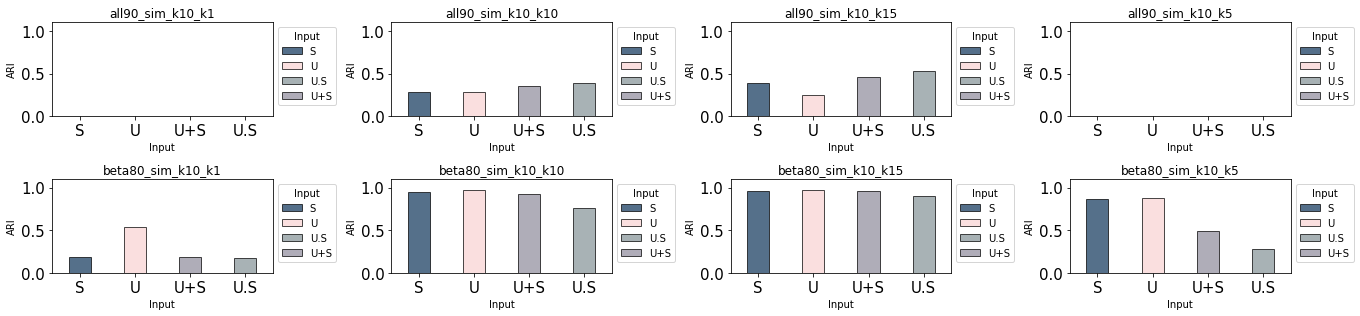

In [65]:
#Make plots of ARI scores for every K-Means run


#Make plots of ARI scores for every K-Means run

aris_df = pd.DataFrame()
aris_df['ARI'] = aris
aris_df['Input'] = in_type
aris_df['K'] = kmeans_k
aris_df['Dataset'] = which_data

palette={'S':'#003366','U':'#FFCCCC', 'U+S':'#8c879e','U.S':'#809499'}

num_cols = len(np.unique(aris_df['K']))
fig, ax = plt.subplots(nrows=int(len(np.unique(which_data))/num_cols), ncols=num_cols, figsize=(19,4.5))

for i in range(len(np.unique(which_data))):
    select = np.unique(which_data)[i]
    sub_ari = aris_df[aris_df.Dataset == select]


    g = sns.barplot(data=sub_ari,x='Input',y='ARI',order=['S','U','U+S','U.S'],
                        hue='Input',palette=palette,edgecolor='black',ax=ax[int(i/num_cols),i%num_cols],
                   alpha=0.7,dodge=False)
    sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
    
    for bar in g.patches:
        x = bar.get_x()
        width = bar.get_width()
        centre = x+width/2.
        newwidth = width/2

        bar.set_x(centre-newwidth/2.)
        bar.set_width(newwidth)

    ax[int(i/num_cols),i%num_cols].set_title(select)
    ax[int(i/num_cols),i%num_cols].set_ylim((0,1.1))
    
    ax[int(i/num_cols),i%num_cols].tick_params(axis='both', which='major', labelsize=15)
    ax[int(i/num_cols),i%num_cols].tick_params(axis='both', which='minor', labelsize=15)
    
plt.tight_layout()
plt.savefig('ari_leiden_sim10.pdf')



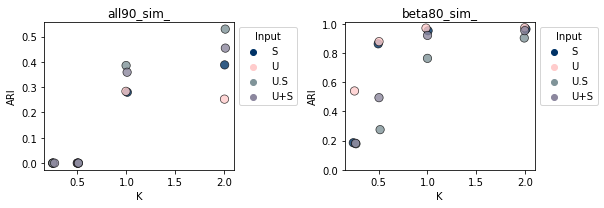

In [71]:
#Make summary ARI plots for each simulation dataset
aris_df['Data_noK'] = [i[0:i.index('k10')] for i in aris_df['Dataset']]


fig, ax = plt.subplots(ncols=int(len(np.unique(which_data))/num_cols), figsize=(8.5,3))

for i in range(len(np.unique(aris_df['Data_noK']))):
    select = np.unique(aris_df['Data_noK'])[i]
    sub_ari = aris_df[aris_df.Data_noK == select]
    g=sns.scatterplot(data=sub_ari,x=sub_ari.K+np.random.normal(0,0.01,len(sub_ari.K)),
                    y='ARI',hue='Input',palette=palette,
                    s=70,edgecolor='black',alpha=0.8,ax=ax[i])
    sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
    ax[i].set_title(select)
    sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
    
plt.ylim((0.0,1.01))
plt.tight_layout()
plt.savefig('ari_leiden_sim10_summary.pdf')


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(7, 7)
(7, 7)


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see ht

(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(17, 17)
(17, 17)
(17, 17)
(17, 17)
(17, 17)
(17, 17)


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(17, 17)
(17, 17)
(17, 17)
(17, 17)
(17, 17)
(17, 17)


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(17, 17)


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see ht

(7, 7)


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see ht

(7, 7)


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(7, 7)


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(43, 43)
(43, 43)
(43, 43)


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(41, 41)


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see ht

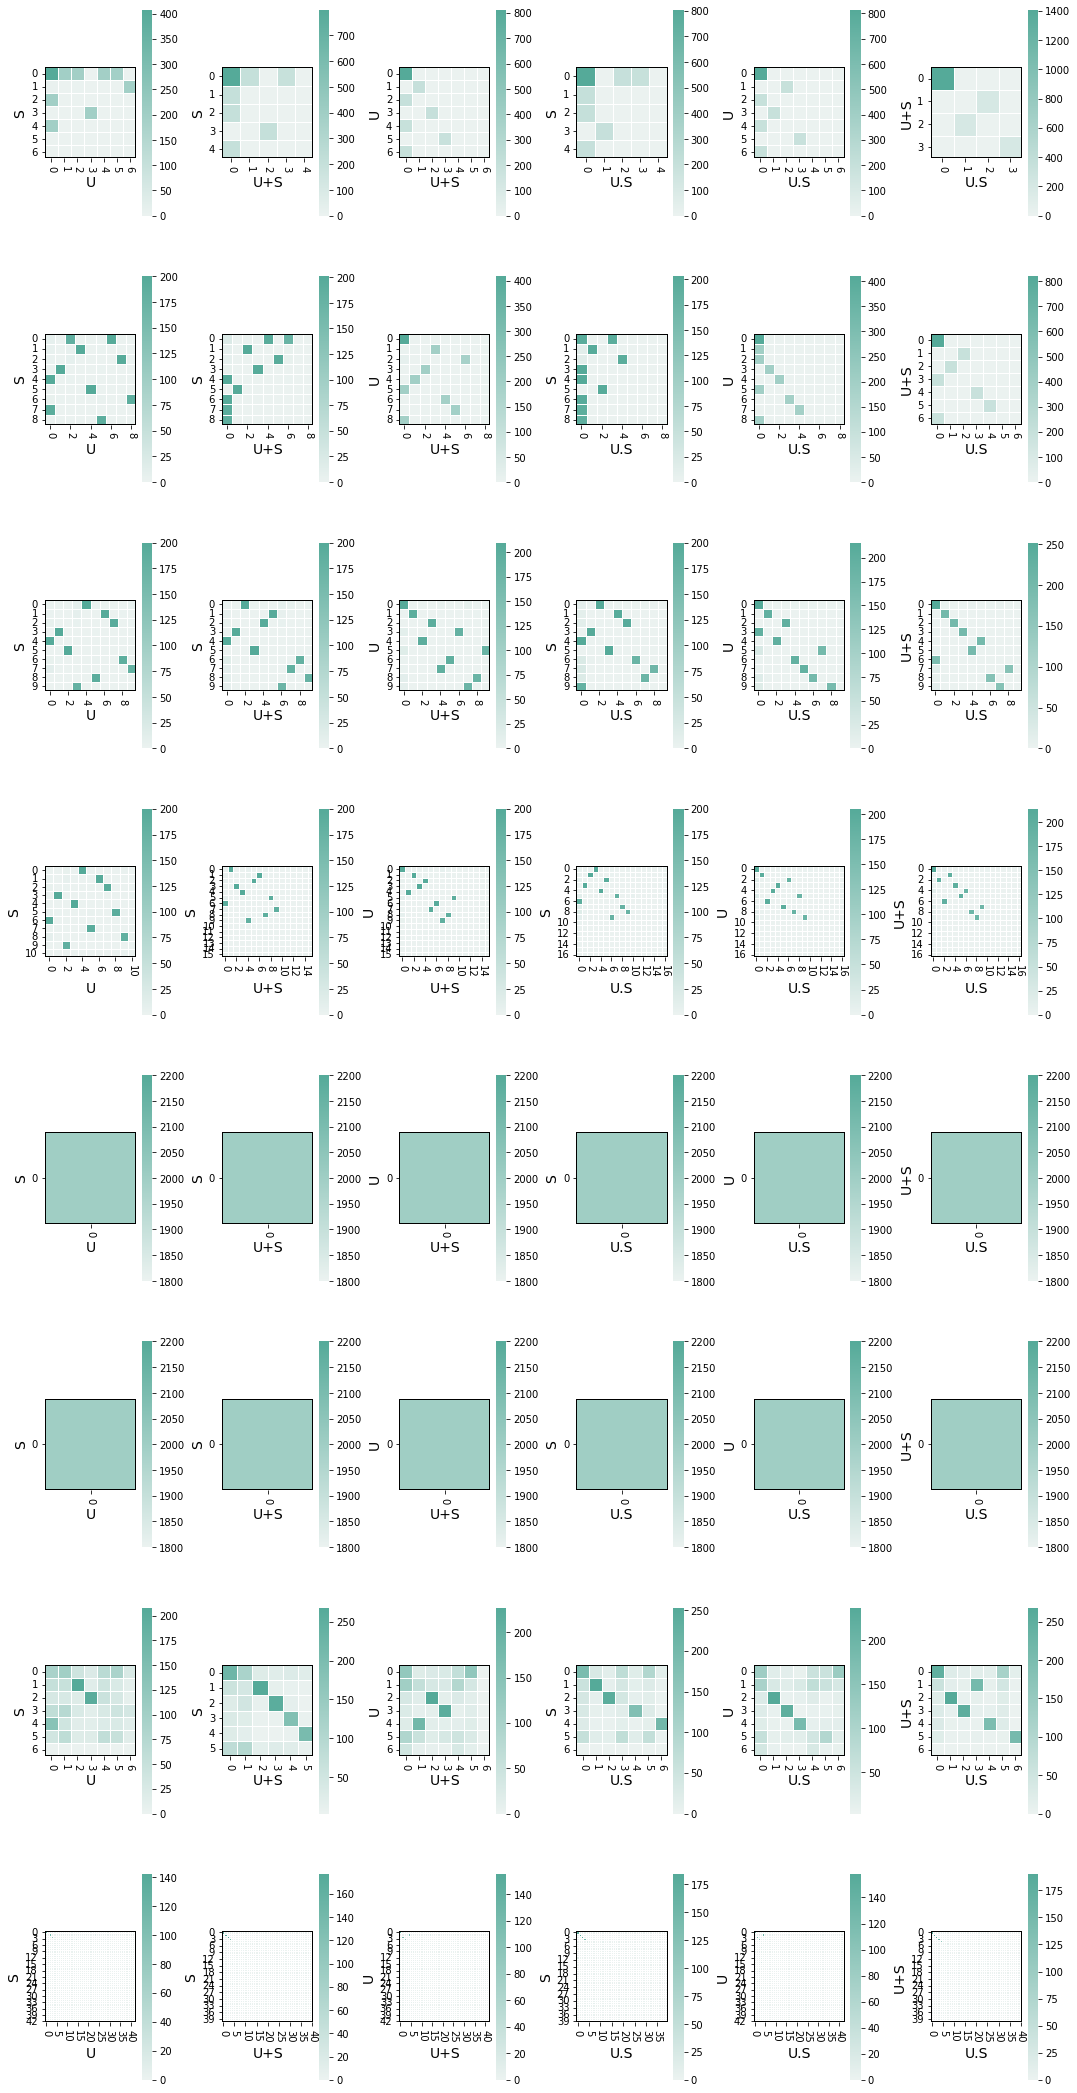

In [226]:
#compare overlap of all leiden assignments (S v U,S v U+S,U v U+S)

num_per_set = len(ks)-3


pairs = [(0,1),(0,3),(1,3),(0,2),(1,2),(3,2)]
labs = [('S','U'),('S','U+S'),('U','U+S'),('S','U.S'),('U','U.S'),('U+S','U.S')]
#Plot confmats

fig, ax = plt.subplots(nrows=num_per_set, ncols=len(pairs), figsize=(15,30))
    
for i in range(0,num_per_set):
    
    for j in range(len(pairs)):
        
        p = pairs[j]
        
        assign = all_groups[p[1]*(num_per_set)+i]
        true = all_groups[p[0]*(num_per_set)+i]

        true_copy = list(true)
        assign_copy = list(assign)

        if np.max(assign) > np.max(true): #FIX
            for a in np.unique(assign):
                if a > np.max(true):
                    true_copy += [a]
                    assign_copy += [a]


        conmat = confusion_matrix(true_copy, assign_copy)
        val = np.mat(conmat) 
        classnames = list(set(true_copy))
        df_cm = pd.DataFrame(

                val, index=classnames, columns=classnames, 

            )


        if np.max(assign) > np.max(true): #FIX
            for a in np.unique(assign):
                if a > np.max(true):
                    print(df_cm.shape)
                    df_cm.loc[a,a] = df_cm.loc[a,a]-1


        heatmap = sns.heatmap(df_cm, annot=False, 
                                  cmap=sns.color_palette("light:#5A9", as_cmap=True),ax=ax[i,j],
                                 square=True,linewidths=1, cbar_kws={"shrink": 0.75})
        heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
        heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0)
        
        heatmap.axhline(y=0, color='k',linewidth=2)
        heatmap.axhline(y=val.shape[1], color='k',linewidth=2)
        heatmap.axvline(x=0, color='k',linewidth=2)
        heatmap.axvline(x=val.shape[0], color='k',linewidth=2)

        ax[i,j].set_ylabel(labs[j][0],fontsize=14)
        ax[i,j].set_xlabel(labs[j][1],fontsize=14)
        
        ax[i,j].tick_params(axis='both', which='minor', labelsize=10,)
        ax[i,j].tick_params(axis='both', which='major', labelsize=10)
        ax[i,j].tick_params(axis='x',labelrotation=-90)

plt.tight_layout()
#plt.show()
plt.savefig('leiden_conf_sim10.pdf')
    

## **Analysis of Results**

In [167]:
#Plot cluster concordance with true labels, and distribution of clusters 
def vis_assign(true,assign,title='',figsize=(18, 5),save_file=None):
    true_copy = list(true)
    assign_copy = list(assign)
    if np.max(assign) > np.max(true): 
        for a in np.unique(assign):
            if a > np.max(true):
                true_copy += [a]
                assign_copy += [a]
    true_copy = np.array(true_copy)
    assign_copy = np.array(assign_copy)
    
    conmat = confusion_matrix(true_copy, assign_copy)
    val = np.mat(conmat) 
    classnames = list(set(true_copy))
    df_cm = pd.DataFrame(

            val, index=classnames, columns=classnames, 

        )
    
    if np.max(assign) > np.max(true): 
        for a in np.unique(assign):
            if a > np.max(true):
                print(df_cm.shape)
                df_cm.loc[a,a] = df_cm.loc[a,a]-1

    #Plot assignment distributions
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    
    g= sns.histplot(x=assign,hue=true, kde=False,ax=ax[0],
                    palette='tab20',multiple="dodge",
                    discrete=True)
    ax[0].set_xlabel('MM Assignment')
    ax[0].set_title(title)
    
    sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))

    
    #Plot confusion matrix
    heatmap = sns.heatmap(df_cm, annot=True, cmap=sns.color_palette("light:#5A9", as_cmap=True),
                          ax=ax[1],square=True,linewidths=1, cbar_kws={"shrink": 0.3})
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',
                                 fontsize=18)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0,
                                fontsize=18)
    
    heatmap.axhline(y=0, color='k',linewidth=2)
    heatmap.axhline(y=val.shape[1], color='k',linewidth=2)
    heatmap.axvline(x=0, color='k',linewidth=2)
    heatmap.axvline(x=val.shape[0], color='k',linewidth=2)

    ax[1].set_ylabel('True State',fontsize=18)
    ax[1].set_xlabel('Assigned State',fontsize=18)
    
    plt.tight_layout()
    if save_file is None:
        plt.show()
    else:
        plt.savefig(save_file)

    

In [108]:
#Plot  aics and loss over time for each k iteration

def vis_metrics(results,title,ks,figsize=(18, 5),s=50,save_file=None):
    num_ks = len(results)
    sets = []
    nlls = []
    res = pd.DataFrame()
    aics = pd.DataFrame()
    klds = pd.DataFrame()
    
    aic = []
    fin_k = []
    kls = []
    
    epoch = len(results[0].all_qs)
    epos = list(range(1,epoch+1))*num_ks
    
    for i in range(num_ks):
        
        nlls += list(-1*np.array(results[i].all_qs))
        sets += [ks[i]]*epoch
        aic += [results[i].aic] #-2*n_cells*clus
        fin_k += [len(np.unique(results[i].assigns))]
        #kls += [np.mean([np.mean(results[i].klds[:,k]) for k in np.unique(results[i].assigns)])]
        
        kls += list(np.mean(np.sum(np.array(results[i].all_klds)[:,:,list(np.unique(results[i].assigns))],axis=1),axis=1))
        
        
    
    
    
    res['NLL'] = nlls
    res['KLD'] = kls
    res['epoch'] = epos
    res['setting'] = [str(j) for j in sets]
    
    aics['AIC'] = aic
    aics['k'] = [str(j) for j in ks ]
    aics['fin_k'] = fin_k
    

    
    
    #Plot klds over time
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=figsize)
    
    sns.lineplot(data=res,x='epoch',y='NLL',hue='setting', 
                    ax=ax[0],palette='Dark2',
                   alpha=0.7,legend=False)
    g=sns.scatterplot(data=res,x='epoch',y='NLL',hue='setting', 
                    ax=ax[0],palette='Dark2',s=s,
                   alpha=0.7,edgecolor='black')
    ax[0].set_xlabel('Epoch',fontsize=12)
    ax[0].set_ylabel('NLL',fontsize=12)
    ax[0].set_title(title)
    ax[0].legend(
          title='Set K')
    sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
    
    
    #Plot klds
    sns.lineplot(data=res,x='epoch',y='KLD',hue='setting', 
                    ax=ax[1],palette='Dark2',
                   alpha=0.7,legend=False)
    g2=sns.scatterplot(data=res,x='epoch',y='KLD',hue='setting', 
                    ax=ax[1],palette='Dark2',s=s,
                   alpha=0.7,edgecolor='black')
    ax[1].set_xlabel('Epoch',fontsize=12)
    ax[1].set_ylabel('KLD',fontsize=12)
    ax[1].legend(
          title='Set K')
    sns.move_legend(g2, "upper left", bbox_to_anchor=(1, 1))

    
    
    #Plot aics
    g3=sns.scatterplot(data=aics,x='fin_k',y='AIC',hue='k', ax=ax[2],palette='Dark2',s=s,
                   alpha=0.7,edgecolor='black')
    ax[2].set_xlabel('Final K',fontsize=12)
    ax[2].set_ylabel('-AIC',fontsize=12)
    ax[2].legend(
          title='Set K')
    sns.move_legend(g3, "upper left", bbox_to_anchor=(1, 1))
    
    
    plt.tight_layout()
    if save_file is None:
        plt.show()
    else:
        plt.savefig(save_file)
    
    
    


In [164]:
#Mixture Model results
import pickle 
results = [i+'/Bursty_Poisson_1x1/grid_point_0.gp' for i in dataset_strings[0:4]]
grid_point_results = []
for r in results:
    with open(r, "rb") as ipfs:
        grid_point_results += [pickle.load(ipfs)]

    

In [165]:
titles_to_save = ['beta80_sim_k10_k10/Bursty_Poisson_1x1']

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


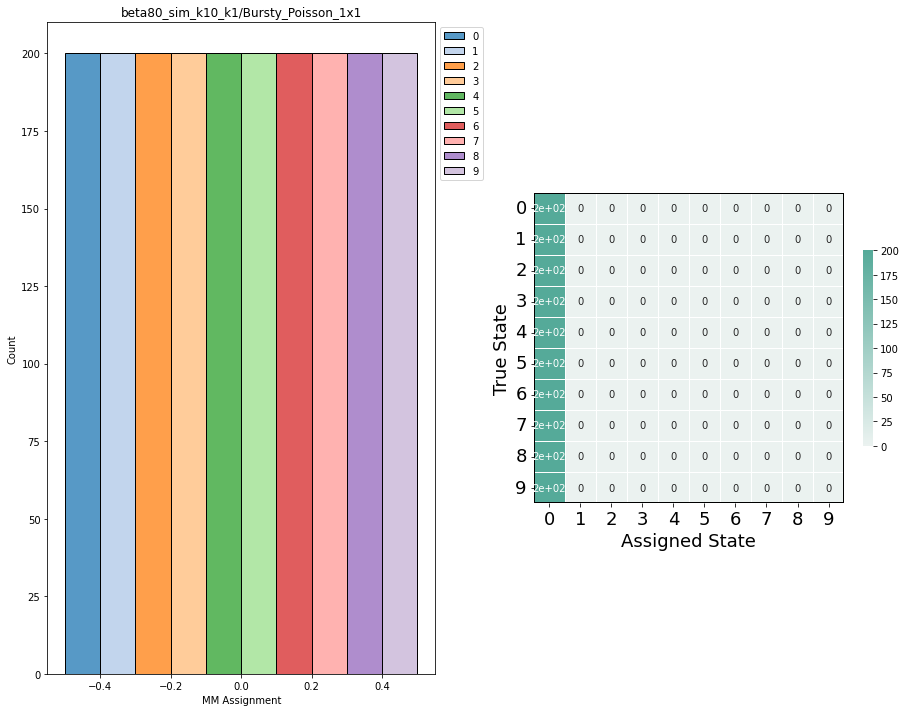

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


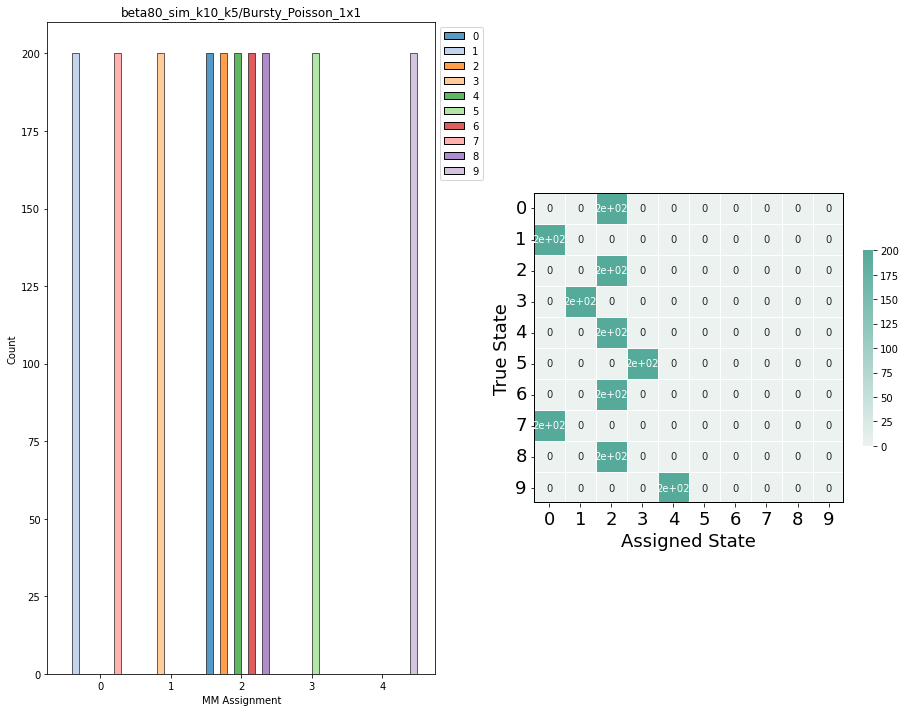

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(14, 14)
(14, 14)
(14, 14)
(14, 14)


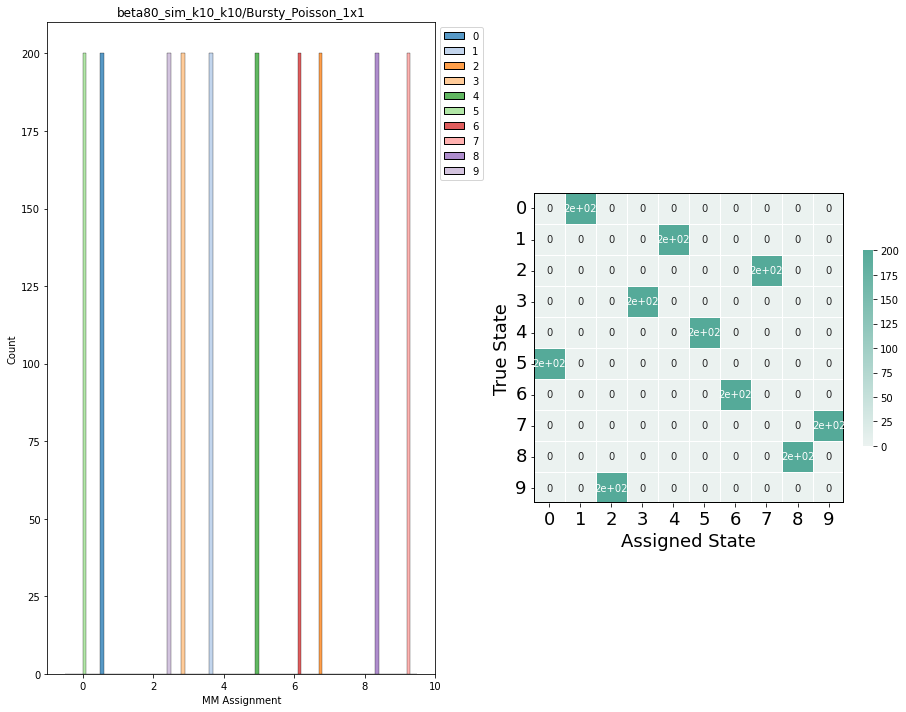

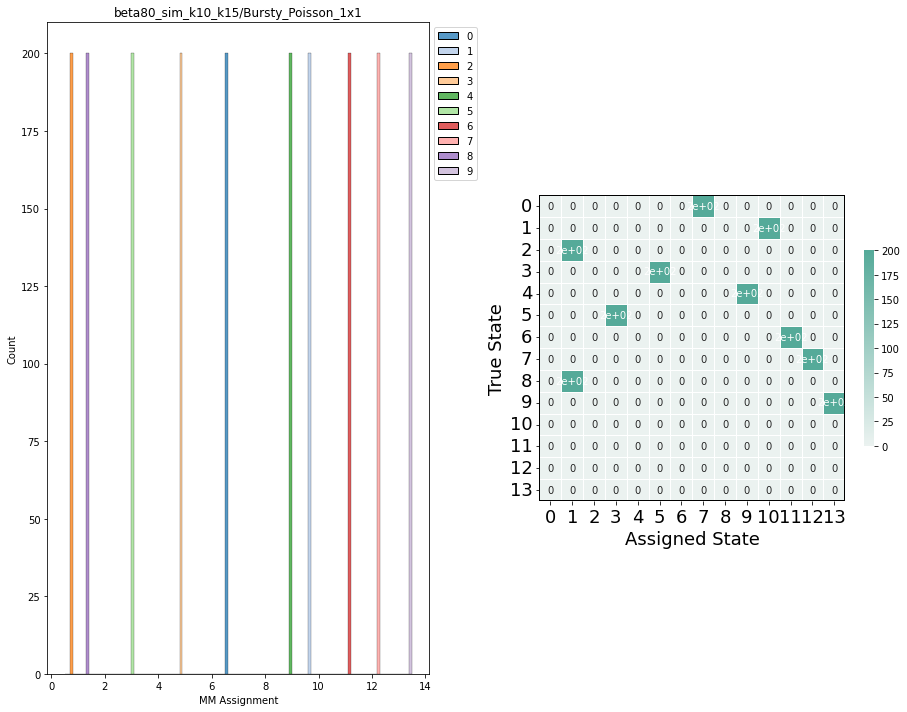

In [168]:
for r in grid_point_results:
    title = r.inference_string.replace('./fits/gg_230505_025_simTests_edgecase_MM_1/','') #./fits/gg_230411_025_simTests_MM_1/
    if title in titles_to_save:
        file_out = title.replace('/','_')+'.pdf'
    else:
        file_out=None
    vis_assign(np.array(all_assigns),r.assigns,title,figsize=(13,10),save_file = file_out) 



In [125]:
titles_to_save = ['beta80_sim_k10']

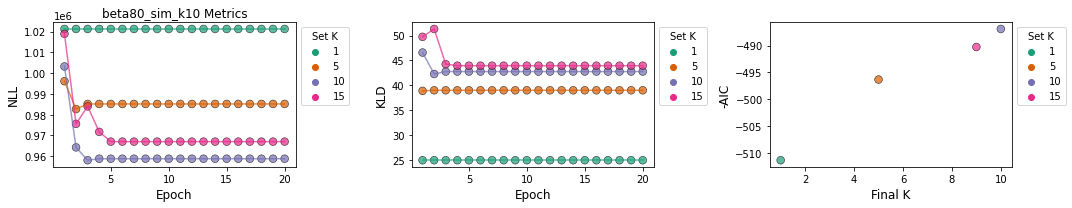

In [128]:

for i in range(0, len(grid_point_results), 4):
    r = grid_point_results[i:i+4]
    title = dataset_meta[i]+' Metrics'
    if dataset_meta[i] in titles_to_save:
        file_out = title.replace(' ','_')+'.pdf'
    else:
        file_out=None
        
    vis_metrics(r,title,ks[i:i+4],figsize=(15,3),s=60,save_file = file_out)

### **Compare MM Fits to Simulation and Monod Fits**

In [129]:
col_all_par = '#4472C4'
col_b = '#1B9AAA'
col_beta = '#9fcbee'
col_gamma ='#3C50B1'
col_expr = '#9299A0'


In [130]:
def check_at_bounds(phys_params,thr=0.01):
    #Check for genes where parameter fits are close to boundary of grid
    x = np.any(np.logical_or(
        np.array(phys_lb)+thr > phys_params,
        np.array(phys_ub)-thr < phys_params) ,1)
    return x

In [131]:
#Check results for burst size > 1
def get_logL(ps,counts,search_data):
    bs = ps[:,0]
    betas = ps[:,1]
    gammas = ps[:,2]
    
    EPS=1e-15
    
    logL = 0
    
    for g in range(n_genes):
        

        x = counts[:,g,:].T
        x = x.astype(int)
        
        b = 10**bs[g]
        beta = 10**betas[g]
        gamma = 10**gammas[g]
        
        
        
        g_len = lens_sub[g]

        lam_n = 10**((glob_samp[0]) + np.log10(g_len))
        lam_m = 10**(glob_samp[1])

        p = np.log10(np.asarray([b,beta,gamma])) #[b,beta,gamma]
        burst_model = BurstModel('Poisson')


        proposal = burst_model.get_Pss(p,search_data.M[:, g],np.log10([lam_n,lam_m]))

        proposal[proposal < EPS] = EPS

        proposal = proposal[tuple(x)]
        logL += np.sum(np.log(proposal))
        
    return logL

In [145]:
def plot_params(all_counts,sr,all_params,grid_point_results,res_inds=[0,0,0],clus_inds=[0,0,0],save_fig=None,figsize=(18,18)):
    
    b_sim_monod = sr[res_inds[0]].param_estimates[clus_inds[0]]
    b_sim_true = all_params[res_inds[1]][clus_inds[1],:,:] #kxgenex6 -->0,2,3 b,beta,gamma
    b_sim_mm = grid_point_results[res_inds[2]].param_estimates[:,:,clus_inds[2]]
    
    filt = ~check_at_bounds(b_sim_mm ,thr=0.01)
    
    #Get true counts + print likelihoods
    true_counts = all_counts[res_inds[1]][0:500,:,:]
   
    
    
    rho =[]
    p = []   
    

    comps = pd.DataFrame()
    comps['b'] = list(b_sim_monod[filt,0])+list(b_sim_true[filt,0])+list(b_sim_mm[filt,0])
    comps['beta'] = list(b_sim_monod[filt,1])+list(b_sim_true[filt,2])+list(b_sim_mm[filt,1])
    comps['gamma'] = list(b_sim_monod[filt,2])+list(b_sim_true[filt,3])+list(b_sim_mm[filt,2])
    comps['setting'] = ['Monod']*np.sum(filt) + ['Sim']*np.sum(filt) + ['meK-Means']*np.sum(filt)


    #Plot param histograms
    fig, ax = plt.subplots(nrows=4, ncols=3, figsize=figsize)

    #b,beta,gamma histograms
    g1=sns.histplot(data=comps,x='b',hue='setting',kde=True,ax=ax[0,0])
    sns.move_legend(g1, "upper left", bbox_to_anchor=(1, 1))
    g2=sns.histplot(data=comps,x='beta',hue='setting',kde=True,ax=ax[0,1])
    sns.move_legend(g2, "upper left", bbox_to_anchor=(1, 1))
    g3=sns.histplot(data=comps,x='gamma',hue='setting',kde=True,ax=ax[0,2])
    sns.move_legend(g3, "upper left", bbox_to_anchor=(1, 1))
    



    #----Plot correlations for Monod vs True------
    comps_monod = comps[comps.setting.isin(['Monod'])]
    comps_true = comps[comps.setting.isin(['Sim'])]
    comps_mm = comps[comps.setting.isin(['meK-Means'])]
    sns.scatterplot(x=list(comps_monod['b']),y=list(comps_true['b']),
                    s=60,edgecolor='black',color=col_b, alpha=0.7,ax=ax[1,0])
    ax[1,0].tick_params(axis='both', which='major', labelsize=14,)
    
    rho += [np.corrcoef(list(comps_monod['b']),y=list(comps_true['b']))[0,1]]
    p += [scipy.stats.spearmanr(list(comps_monod['b']),list(comps_true['b']))[0]]

    sns.scatterplot(x=list(comps_monod['beta']),y=list(comps_true['beta']),
                    s=60,edgecolor='black',color=col_beta, alpha=0.7,ax=ax[1,1],legend=False)
    ax[1,1].tick_params(axis='both', which='major', labelsize=14,)
    
    rho += [np.corrcoef(list(comps_monod['beta']),list(comps_true['beta']))[0,1]]
    p += [scipy.stats.spearmanr(list(comps_monod['beta']),list(comps_true['beta']))[0]]


    sns.scatterplot(x=list(comps_monod['gamma']),y=list(comps_true['gamma']),
                    s=60,edgecolor='black',color=col_gamma, alpha=0.7,ax=ax[1,2],legend=False)
    ax[1,2].tick_params(axis='both', which='major', labelsize=14,)
    
    rho += [np.corrcoef(list(comps_monod['gamma']),list(comps_true['gamma']))[0,1]]
    p += [scipy.stats.spearmanr(list(comps_monod['gamma']),list(comps_true['gamma']))[0]]
    
    ax[1,0].set_xlabel('Monod',fontsize=14)
    ax[1,0].set_ylabel('True',fontsize=14)



    #-----Plot correlations for monod v mek-means----
    sns.scatterplot(x=list(comps_monod['b']),y=list(comps_mm['b']),
                    s=60,edgecolor='black',color=col_b, alpha=0.7,ax=ax[2,0])
    ax[2,0].tick_params(axis='both', which='major', labelsize=14,)
    
    rho += [np.corrcoef(list(comps_monod['b']),list(comps_mm['b']))[0,1]]
    p += [scipy.stats.spearmanr(list(comps_monod['b']),list(comps_mm['b']))[0]]
    

    sns.scatterplot(x=list(comps_monod['beta']),y=list(comps_mm['beta']),
                    s=60,edgecolor='black',color=col_beta, alpha=0.7,ax=ax[2,1],legend=False)
    ax[2,1].tick_params(axis='both', which='major', labelsize=14,)
    rho += [np.corrcoef(list(comps_monod['beta']),list(comps_mm['beta']))[0,1]]
    p += [scipy.stats.spearmanr(list(comps_monod['beta']),list(comps_mm['beta']))[0]]


    sns.scatterplot(x=list(comps_monod['gamma']),y=list(comps_mm['gamma']),
                    s=60,edgecolor='black',color=col_gamma, alpha=0.7,ax=ax[2,2],legend=False)
    ax[2,2].tick_params(axis='both', which='major', labelsize=14,)
    rho += [np.corrcoef(list(comps_monod['gamma']),list(comps_mm['gamma']))[0,1]]
    p += [scipy.stats.spearmanr(list(comps_monod['gamma']),list(comps_mm['gamma']))[0]]
    
    ax[2,0].set_xlabel('Monod',fontsize=14)
    ax[2,0].set_ylabel('meK-Means',fontsize=14)


    #----Plot correlations for true vs mek-means----
    sns.scatterplot(x=list(comps_mm['b']),y=list(comps_true['b']),
                    s=60,edgecolor='black',color=col_b, alpha=0.7,ax=ax[3,0])
    ax[3,0].tick_params(axis='both', which='major', labelsize=14,)
    rho += [np.corrcoef(list(comps_mm['b']),list(comps_true['b']))[0,1]]
    p += [scipy.stats.spearmanr(list(comps_mm['b']),list(comps_true['b']))[0]]

    sns.scatterplot(x=list(comps_mm['beta']),y=list(comps_true['beta']),
                    s=60,edgecolor='black',color=col_beta, alpha=0.7,ax=ax[3,1],legend=False)
    ax[3,1].tick_params(axis='both', which='major', labelsize=14,)
    rho += [np.corrcoef(list(comps_mm['beta']),list(comps_true['beta']))[0,1]]
    p += [scipy.stats.spearmanr(list(comps_mm['beta']),list(comps_true['beta']))[0]]


    sns.scatterplot(x=list(comps_mm['gamma']),y=list(comps_true['gamma']),
                    s=60,edgecolor='black',color=col_gamma, alpha=0.7,ax=ax[3,2],legend=False)
    ax[3,2].tick_params(axis='both', which='major', labelsize=14,)
    rho += [np.corrcoef(list(comps_mm['gamma']),list(comps_true['gamma']))[0,1]]
    p += [scipy.stats.spearmanr(list(comps_mm['gamma']),list(comps_true['gamma']))[0]]
    
    ax[3,0].set_xlabel('meK-Means',fontsize=14)
    ax[3,0].set_ylabel('True',fontsize=14)
    
    
    for i, a in enumerate(ax.flat):

        if i not in [0,1,2]:
            bot,top = a.get_ylim()
            l,r = a.get_xlim()

            newl = np.min([bot,l])
            newr = np.max([top,r])

            a.set_xlim((newl,newr))
            a.set_ylim((newl,newr))
            
            a.text(.05,.6,r'$r$ = {:.2f}'.format(rho[i-3]),fontsize=15,transform=a.transAxes)
            a.text(.05,.8,r'$\rho$ = {:.2f}'.format(p[i-3]),fontsize=15,transform=a.transAxes)
            
            a.plot(a.get_xlim(),a.get_xlim(),'--',color=[116/255,112/255,113/255],linewidth=3,alpha=0.4)
        
        
    plt.tight_layout()
    if save_fig is None:
        plt.show()
    else:
        plt.savefig(save_fig)
        

In [151]:
#Plot parameter distributions vs true params only, without Standard Monod results
def plot_true_params(all_counts,all_params,grid_point_results,res_inds=[0,0],clus_inds=[0,0],figsize=(18,18),save_fig=None):
    
    b_sim_true = all_params[res_inds[0]][clus_inds[0],:,:] #kxgenex6 -->0,2,3 b,beta,gamma
    b_sim_mm = grid_point_results[res_inds[1]].param_estimates[:,:,clus_inds[1]]
    
    filt = ~check_at_bounds(b_sim_mm ,thr=0.01)
    
    rho =[]
    p = []   
    
    

    comps = pd.DataFrame()
    comps['b'] = list(b_sim_true[filt,0])+list(b_sim_mm[filt,0])
    comps['beta'] = list(b_sim_true[filt,2])+list(b_sim_mm[filt,1])
    comps['gamma'] = list(b_sim_true[filt,3])+list(b_sim_mm[filt,2])
    comps['setting'] = ['True']*np.sum(filt) + ['meK-Means']*np.sum(filt)


    #Plot param histograms
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=figsize)


    #Plot correlations
    comps_true = comps[comps.setting.isin(['True'])]
    comps_mm = comps[comps.setting.isin(['meK-Means'])]


    #mm v true
    g=sns.scatterplot(x=list(comps_mm['b']),y=list(comps_true['b']),
                    s=50,edgecolor='black',color=col_b, alpha=0.7,ax=ax[0])
    #ax[3,0].text(x=-1, y=2, s=np.corrcoef(list(comps_mm['b']),list(comps_true['b']))[0,1])
    rho += [np.corrcoef(list(comps_mm['b']),list(comps_true['b']))[0,1]]
    p += [scipy.stats.spearmanr(list(comps_mm['b']),list(comps_true['b']))[0]]
   

    g1=sns.scatterplot(x=list(comps_mm['beta']),y=list(comps_true['beta']),
                    s=50,edgecolor='black',color=col_beta, alpha=0.7,ax=ax[1],legend=False)
    #ax[3,1].text(x=-1, y=0.5, s=np.corrcoef(list(comps_mm['beta']),list(comps_true['beta']))[0,1])
    rho += [np.corrcoef(list(comps_mm['beta']),list(comps_true['beta']))[0,1]]
    p += [scipy.stats.spearmanr(list(comps_mm['beta']),list(comps_true['beta']))[0]]
    


    g2=sns.scatterplot(x=list(comps_mm['gamma']),y=list(comps_true['gamma']),
                    s=50,edgecolor='black',color=col_gamma, alpha=0.7,ax=ax[2],legend=False)
    #ax[3,2].text(x=-1, y=0.5, s=np.corrcoef(list(comps_mm['gamma']),list(comps_true['gamma']))[0,1])
    rho += [np.corrcoef(list(comps_mm['gamma']),list(comps_true['gamma']))[0,1]]
    p += [scipy.stats.spearmanr(list(comps_mm['gamma']),list(comps_true['gamma']))[0]]

    
    ax[0].set_xlabel('meK-Means')
    ax[0].set_ylabel('True')
    
    
    for i, a in enumerate(ax.flat):


        bot,top = a.get_ylim()
        l,r = a.get_xlim()

        newl = np.min([bot,l])
        newr = np.max([top,r])

        a.set_xlim((newl,newr))
        a.set_ylim((newl,newr))

        a.text(.05,.7,r'$r$ = {:.2f}'.format(rho[i-3]),fontsize=14,transform=a.transAxes)
        a.text(.05,.8,r'$\rho$ = {:.2f}'.format(p[i-3]),fontsize=14,transform=a.transAxes)

        a.plot(a.get_xlim(),a.get_xlim(),'--',color=[116/255,112/255,113/255],linewidth=3,alpha=0.4)



    
    plt.tight_layout()
    if save_fig is None:
        plt.show()
    else:
        plt.savefig(save_fig)

In [756]:
dataset_names

['beta80_sim_k10_k1',
 'beta80_sim_k10_k5',
 'beta80_sim_k10_k10',
 'beta80_sim_k10_k15',
 'all90_sim_k10_k1',
 'all90_sim_k10_k5',
 'all90_sim_k10_k10',
 'all90_sim_k10_k15',
 'oneClus_beta80_sim_k10_k1',
 'oneClus_all90_sim_k10_k1']

In [132]:
out_path = '/home/tchari/counts/mixMod_edgecase_sims/loom/'
all_params = np.load(out_path+'all_params.npy')
all_marks= np.load(out_path+'all_marks.npy')

In [133]:
#Recreate all_counts from saved looms
reread_looms = list(pd.unique([out_path+i+'.loom' for i in dataset_meta[:-3]]))

all_counts = []
for r in reread_looms:
    new_counts = np.zeros((clus*n_cells,n_genes,2))
    ds = lp.connect(r)
    old_u = ds.layers['unspliced'][:,:].T
    old_s = ds.layers['spliced'][:,:].T
    new_counts[:,:,0] = old_u
    new_counts[:,:,1] = old_s
    
    all_counts += [new_counts]
    ds.close()


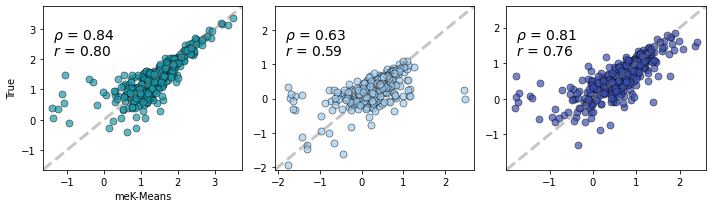

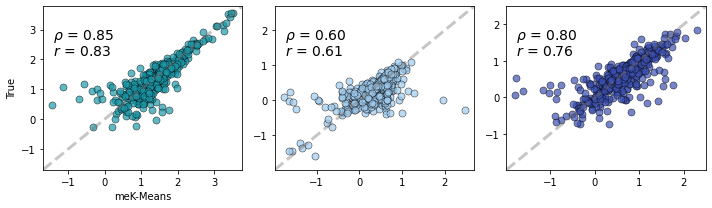

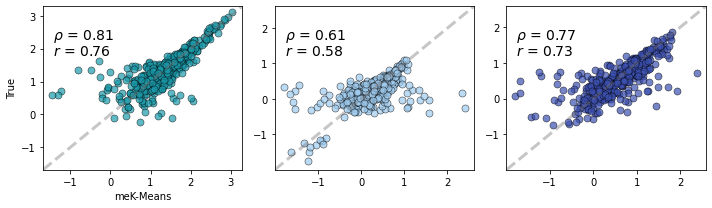

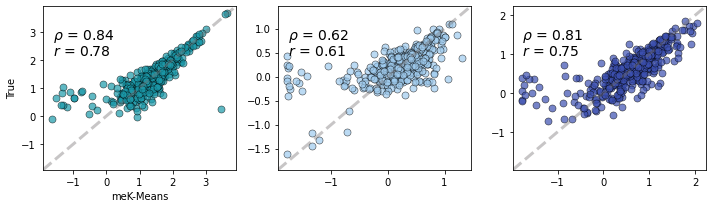

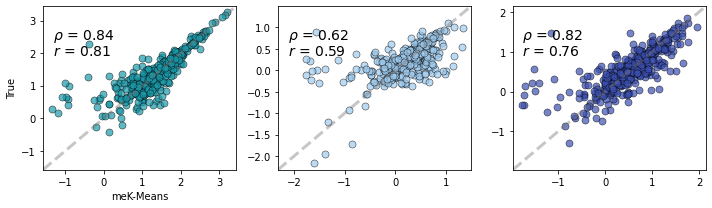

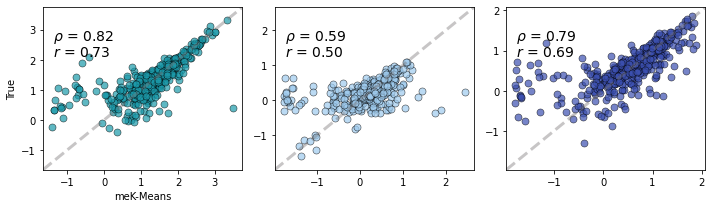

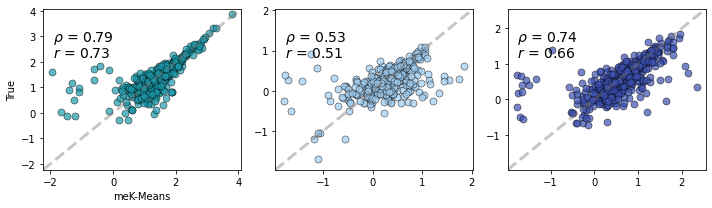

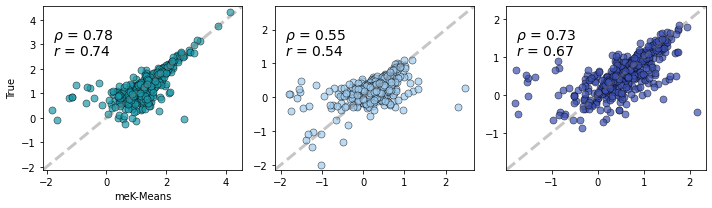

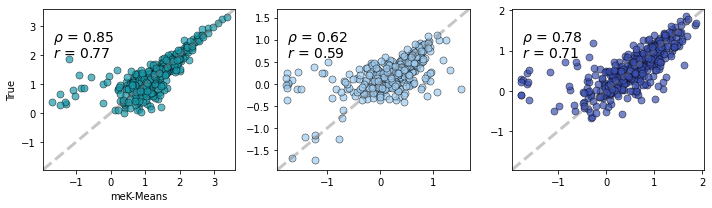

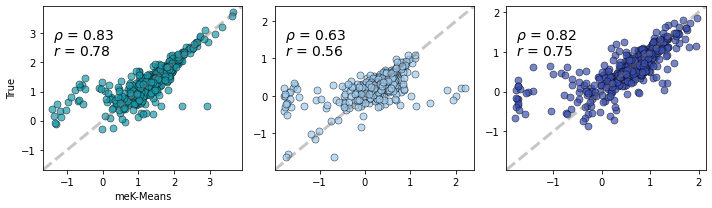

In [154]:
pairs = [(0,1),(1,4),(2,7),(3,3),(4,5),(5,0),(6,6),(7,9),(8,8),(9,2)]
for p in pairs:
    plot_true_params(all_counts,all_params,grid_point_results,res_inds=[0,2],clus_inds=[p[0],p[1]],figsize=(10,3))

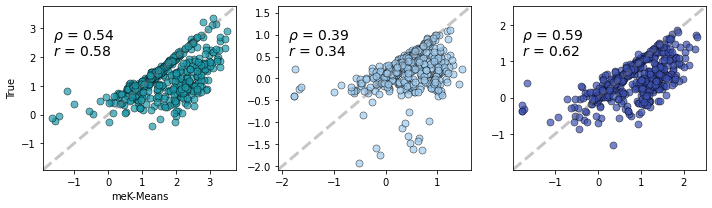

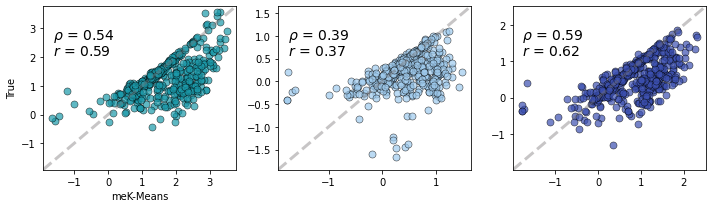

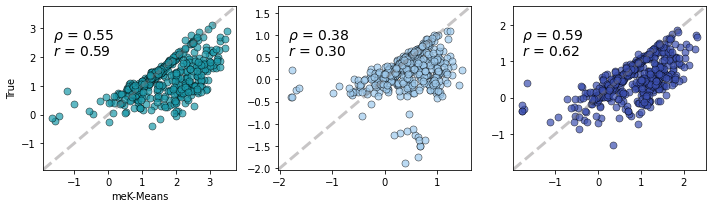

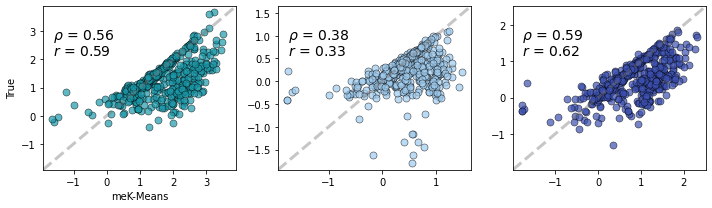

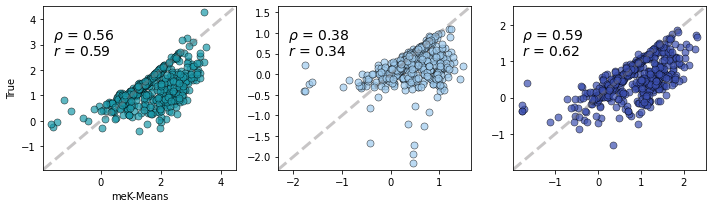

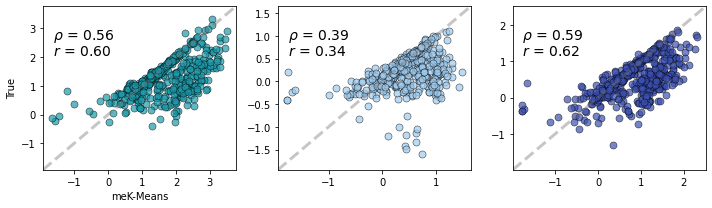

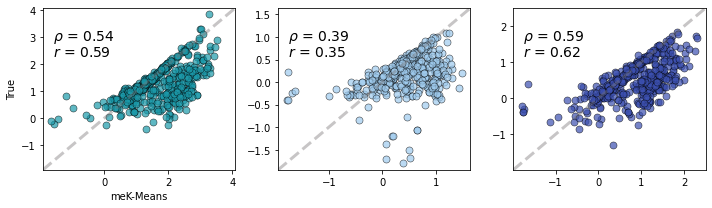

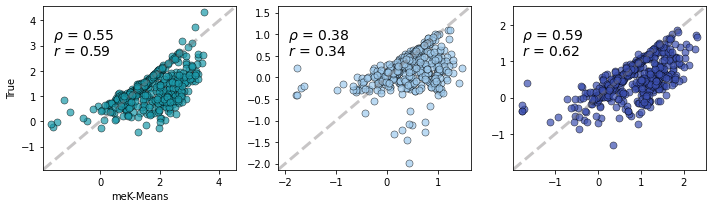

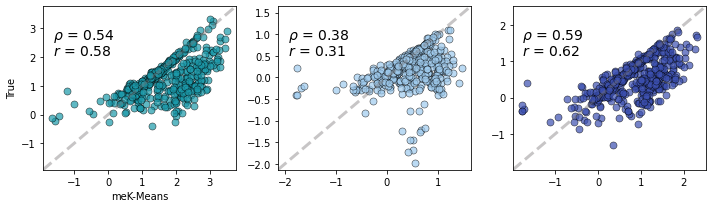

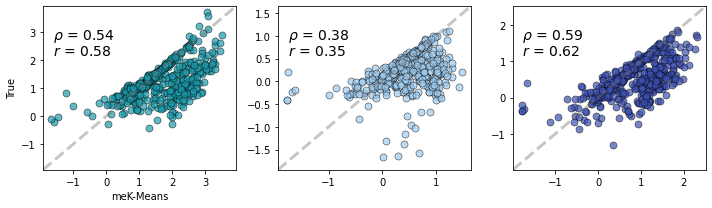

In [155]:
#Compare param fits when K=1
pairs = [(0,1),(1,4),(2,7),(3,3),(4,5),(5,0),(6,6),(7,9),(8,8),(9,2)]
for p in pairs:
    plot_true_params(all_counts,all_params,grid_point_results,res_inds=[0,0],clus_inds=[p[0],0],figsize=(10,3))

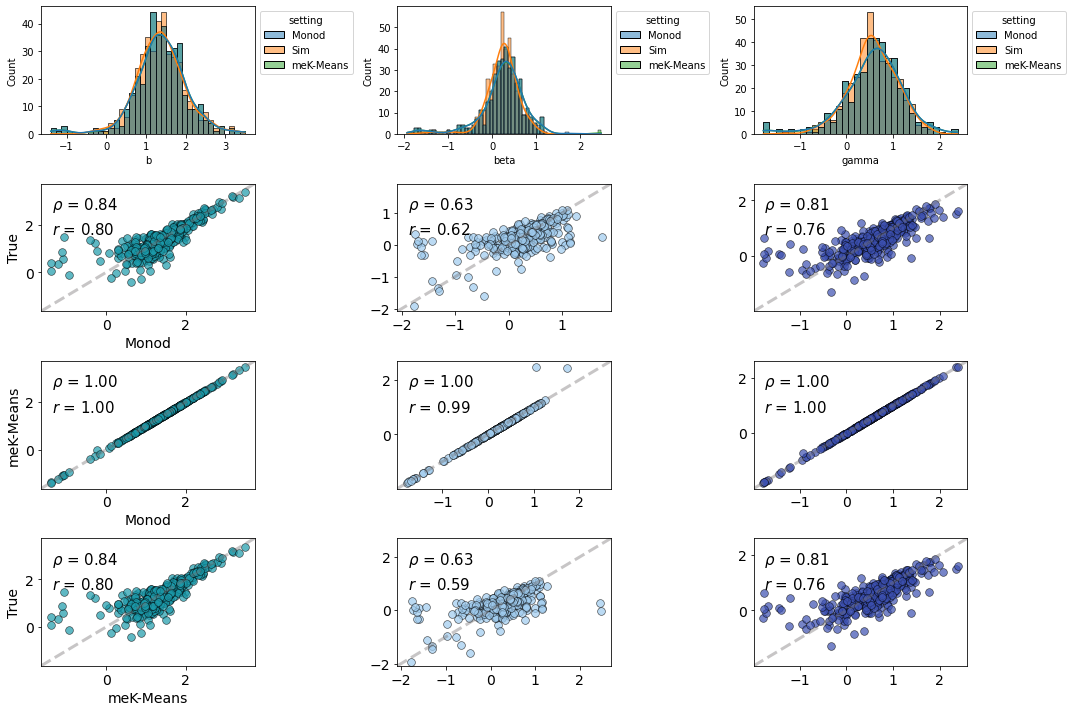

In [148]:
#Compare parameter fits with Monod, fo single cluster examples
plot_params(all_counts,sr,all_params,grid_point_results,res_inds=[0,0,2],clus_inds=[0,0,1],
            save_fig='beta80_param_fits.pdf',figsize=(15,10))

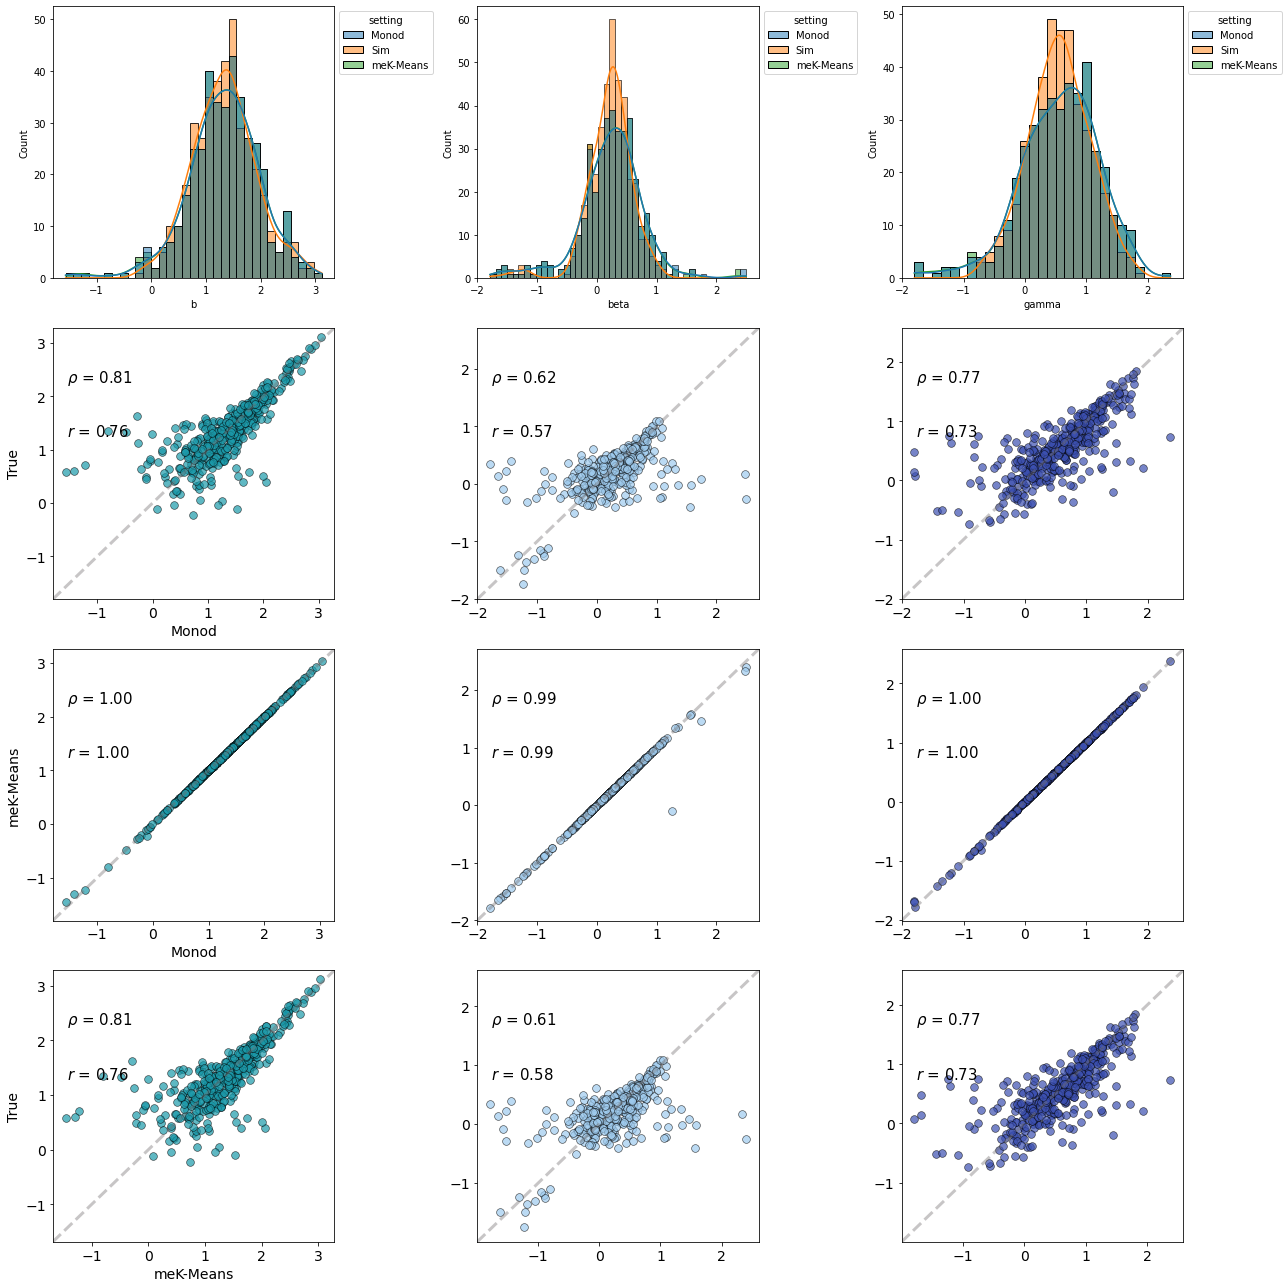

In [147]:
#Compare parameter fits with Monod, fo single cluster examples
plot_params(all_counts,sr,all_params,grid_point_results,res_inds=[1,0,2],clus_inds=[0,2,7])

**Make plots of params for marker genes between the cell states**

          b      beta     gamma         state
0  1.153225 -1.302453  0.605242  Marked State
1  2.349772  0.446471  0.440337  Marked State
2  3.492219  0.554883  0.820616  Marked State
3  1.490901 -1.429981  0.229304  Marked State
4  2.009429  0.041653  0.428780  Marked State


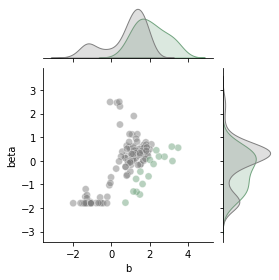

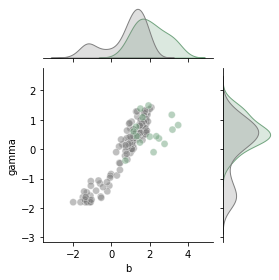

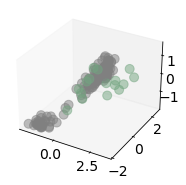

In [161]:
marker_clus = 1
true_clus = 0

allinds = np.array(range(n_genes))
other_inds = [i for i in range(10) if i != marker_clus]

filt = ~check_at_bounds(grid_point_results[2].param_estimates[:,:,marker_clus] ,thr=0.01) 

marks = all_marks[0][true_clus*20:(true_clus*20+20)]
toplot = [i for i in marks if i in list(allinds[filt])]

all_b_beta = pd.DataFrame()
all_b_beta['b'] = list(grid_point_results[2].param_estimates[toplot,0,marker_clus]) + list(grid_point_results[2].param_estimates[toplot,0,:][:,other_inds].flatten())
all_b_beta['beta'] = list(grid_point_results[2].param_estimates[toplot,1,marker_clus]) + list(grid_point_results[2].param_estimates[toplot,1,:][:,other_inds].flatten())
all_b_beta['gamma'] = list(grid_point_results[2].param_estimates[toplot,2,marker_clus]) + list(grid_point_results[2].param_estimates[toplot,2,:][:,other_inds].flatten())
all_b_beta['state'] = ['Marked State']*len(toplot) + ['Other States']*len(toplot)*9


print(all_b_beta.head())

palette={'Marked State':'#73a580','Other States':'grey'}

sns.jointplot(data=all_b_beta.sort_values('state',ascending=False), x="b", y="beta", hue="state",
              alpha=0.5,s=50,height=4,
              ratio=3,palette=palette,legend=False,marginal_kws={'common_norm':False})

plt.savefig('beta80_2d_mark_beta.pdf')

sns.jointplot(data=all_b_beta.sort_values('state',ascending=False), x="b", y="gamma", hue="state",
              alpha=0.5,s=50,height=4,
              ratio=3,palette=palette,legend=False,marginal_kws={'common_norm':False})

plt.savefig('beta80_2d_mark_gamma.pdf')

plt.show()


fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(projection='3d')

all_colors = [palette[i] for i in all_b_beta['state']]
ax.scatter(all_b_beta['b'], all_b_beta['beta'], all_b_beta['gamma'],
           c=all_colors,s=80,alpha=0.5)
ax.tick_params(axis='both', which='major', labelsize=14,pad=-3)


ax.grid(None)



plt.savefig('beta80_3d_mark.pdf')

          b      beta     gamma         state
0  1.432628 -0.949316  0.443594  Marked State
1  2.013310  0.096596 -0.171440  Marked State
2  2.588697  0.120060  0.420545  Marked State
3  2.865185  0.417447  0.999097  Marked State
4  2.750240  0.400442  0.693459  Marked State


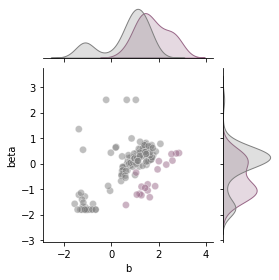

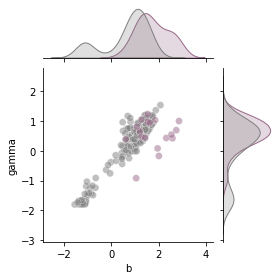

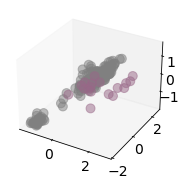

In [162]:
marker_clus = 7
true_clus = 2

other_inds = [i for i in range(10) if i != marker_clus]

filt = ~check_at_bounds(grid_point_results[2].param_estimates[:,:,marker_clus] ,thr=0.01) 

marks = all_marks[0][true_clus*20:(true_clus*20+20)]
toplot = [i for i in marks if i in list(allinds[filt])]

all_b_beta = pd.DataFrame()
all_b_beta['b'] = list(grid_point_results[2].param_estimates[toplot,0,marker_clus]) + list(grid_point_results[2].param_estimates[toplot,0,:][:,other_inds].flatten())
all_b_beta['beta'] = list(grid_point_results[2].param_estimates[toplot,1,marker_clus]) + list(grid_point_results[2].param_estimates[toplot,1,:][:,other_inds].flatten())
all_b_beta['gamma'] = list(grid_point_results[2].param_estimates[toplot,2,marker_clus]) + list(grid_point_results[2].param_estimates[toplot,2,:][:,other_inds].flatten())
all_b_beta['state'] = ['Marked State']*len(toplot) + ['Other States']*len(toplot)*9


print(all_b_beta.head())


palette={'Marked State':'#996888','Other States':'grey'}


sns.jointplot(data=all_b_beta.sort_values('state',ascending=False), x="b", y="beta", hue="state",
              alpha=0.5,s=50,height=4,
              ratio=3,palette=palette,legend=False,marginal_kws={'common_norm':False})

plt.savefig('beta80_2d_mark2_beta.pdf')

sns.jointplot(data=all_b_beta.sort_values('state',ascending=False), x="b", y="gamma", hue="state",
              alpha=0.5,s=50,height=4,
              ratio=3,palette=palette,legend=False,marginal_kws={'common_norm':False})



plt.savefig('beta80_2d_mark2_gamma.pdf')


fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(projection='3d')

all_colors = [palette[i] for i in all_b_beta['state']]
ax.scatter(all_b_beta['b'], all_b_beta['beta'], all_b_beta['gamma'],
           c=all_colors,s=80,alpha=0.5)
ax.tick_params(axis='both', which='major', labelsize=14,pad=-3)


ax.grid(None)

plt.savefig('beta80_3d_mark2.pdf')
